# Modeling LGN-V1 connections

This notebook will be used to model/schematize the construction of V1 receptive fields from LGN inputs. In particular, we want to analyze how the spatial arrangement of inputs and the tuning of the LGN neurons themselves influence V1 selectivity, and ask if the LGN arrangement/tuning matters for all - or only some - V1 neurons.

Last access (y.m.d):  20.07.24   
Last update (y.m.d):  20.07.23   

In [1264]:
import numpy as np
import autoreload
import helper_fcns as hf
import lgn_v1
import scipy.optimize as opt
from scipy.ndimage import gaussian_filter as gauss_filt
import itertools
import os
import warnings
import pandas as pd
warnings.filterwarnings('once')

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import matplotlib.colors as mplclr
import seaborn as sns

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

%matplotlib inline 

base_dir = os.getcwd() + '/';

saveName = 'figures/reports/LGN_V1/' # for one save name for all figures
save_loc = base_dir + saveName;

In [1265]:
from matplotlib import rcParams
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 42 # should be 42; 3 works if there are kerning issues
rcParams['ps.fonttype'] = 42 # should be 42; 3 works if there are kerning issues


# Contents
- Haphazard wiring (Ringach et al, '04 model)
- VNL's LGN database analysis
- V1 full population tuning curves
- Construction of the LGN front-end  
    - SF, RVC tuning curves  
    - Analysis of how M vs. P weighting influences tuning  

# Haphazard wiring

Let's try and recreate Ringach 2004. Here, he defines a hexagonal latice: 

$\vec{\mathbf{x}}$ = $\lambda$ * $\begin{pmatrix} 1 & 1 \\\ \sqrt{3} & -\sqrt{3} \end{pmatrix}$ * $\begin{pmatrix} i \\\ j \end{pmatrix}$ + $\vec{n}$

### First, the retinal mosaic

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


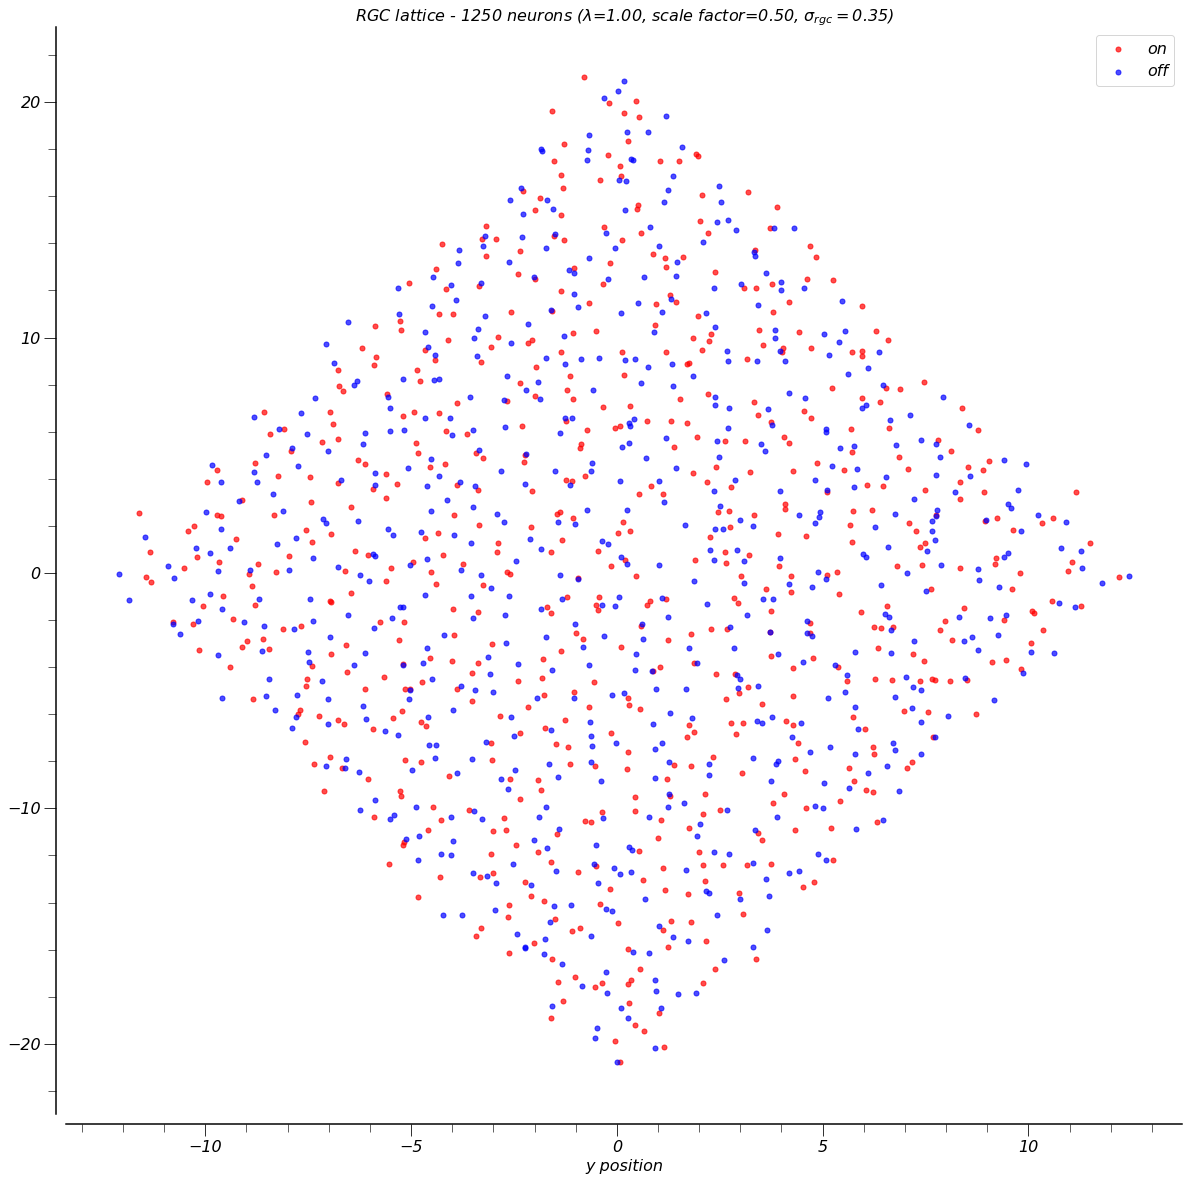

In [320]:
latNum = latNum+1;
# latNum = -1;

nsteps = 12;
sc_factor=1/2.0;
lm=1;
sig_ringach = 0.355; # default is 0.155

on_locs, off_locs = lgn_v1.rgc_lattice(nsteps, sc_factor=sc_factor, lmda=lm, sig_pos=sig_ringach)
f = plt.figure(figsize=(20, 20));

plt.scatter(on_locs[:, 0], on_locs[:, 1], c='r', alpha=0.7, label='on');
plt.scatter(off_locs[:, 0], off_locs[:, 1], c='b', alpha=0.7, label='off');

plt.axis('equal');
plt.axis('tight');
plt.xlabel('x position')
plt.xlabel('y position')
plt.title(r'RGC lattice - %d neurons ($\lambda$=%.2f, scale factor=%.2f, $\sigma_{rgc}=%.2f$)' % (len(on_locs)+len(off_locs), lm, sc_factor, sig_ringach));
plt.legend();
sns.despine(offset=10)

In [321]:
### Now, compute the distribution of distances between locations - first within class then, across
# within class:
on_min = [];
off_min = [];
for i,j in zip(on_locs, off_locs):
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    on_min.append(np.partition(np.sqrt(np.sum(np.square(i - on_locs), 1)), 1)[1])
    off_min.append(np.partition(np.sqrt(np.sum(np.square(j - off_locs), 1)), 1)[1])

for dta, lbl in zip((on_min, off_min), ('on', 'off')):
    mn, sd = np.mean(dta), np.std(dta);
    cv = np.divide(sd, mn);
    print('%s: mn %.2f +- %.2f --- CV %.3f' % (lbl, mn, sd, cv))
    
# independent of class:
all_locs = np.vstack((on_locs, off_locs));
both_min = [];
for i in all_locs:
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    both_min.append(np.partition(np.sqrt(np.sum(np.square(i - all_locs), 1)), 1)[1])
    
mn_both, sd_both = np.mean(both_min), np.std(both_min);
cv_both = np.divide(sd_both, mn_both);
print('%s: mn %.2f +- %.2f --- CV %.3f' % ('all locations', mn_both, sd_both, cv_both))

on: mn 0.54 +- 0.25 --- CV 0.454
off: mn 0.56 +- 0.24 --- CV 0.422
all locations: mn 0.35 +- 0.18 --- CV 0.501


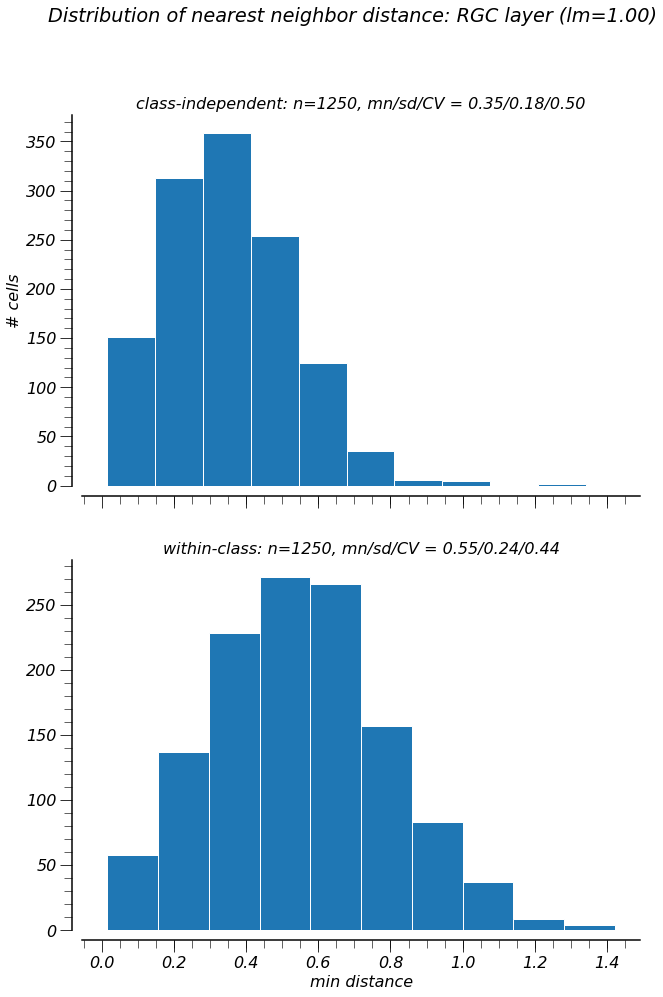

In [322]:
all_dist_within = np.hstack((on_min, off_min));
all_mean, all_std = np.mean(all_dist_within), np.std(all_dist_within);
all_cv = np.divide(all_std, all_mean)

fDistr, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True)
fDistr.suptitle('Distribution of nearest neighbor distance: RGC layer (lm=%.2f)' % lm)

sns.despine(offset=10)

ax[0].hist(both_min);
ax[0].set_title('class-independent: n=%d, mn/sd/CV = %.2f/%.2f/%.2f' % (len(both_min), mn_both, sd_both, cv_both));
ax[0].set_ylabel('# cells');

ax[1].hist(all_dist_within);
ax[1].set_title('within-class: n=%d, mn/sd/CV = %.2f/%.2f/%.2f' % (len(all_dist_within), all_mean, all_std, all_cv));
ax[1].set_xlabel('min distance');


In [323]:
### Save the lattice and the distributions

f_lat = [f, fDistr]; # in future, add fLat before this

curr_name = 'lat%03d_distr.pdf' % (latNum)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + curr_name);
for fc in f_lat:
    # first, save png of just the one figure
    # then, add to the pdf
    pdfSv.savefig(fc)
    plt.close(fc)
pdfSv.close();

### Then, create the LGN layer

_"The layer of LGN neurons was constructed by replicating the original RGC layer and adding 1.5 times more receptive fields. This was done by random sampling (with replacement) to result in a total of 2.5 times the number of original RGCs. This assumes that each LGN neuron receives dominant input from only one retinal afferent (Cleland and Lee 1985; Cleland et al. 1971)"_ - Ringach, 2004

In [324]:
# resampling 1.5x the RGC layer is for cat
# -- we can assume 1:1 for RGC:LGN in monkey, thus no resampling needed, so n_to_draw is 0!
resamp_factor = 0;
LGN_locs, LGN_ids, on_inds, off_inds = lgn_v1.lgn_lattice(on_locs, off_locs, resample_factor=resamp_factor);

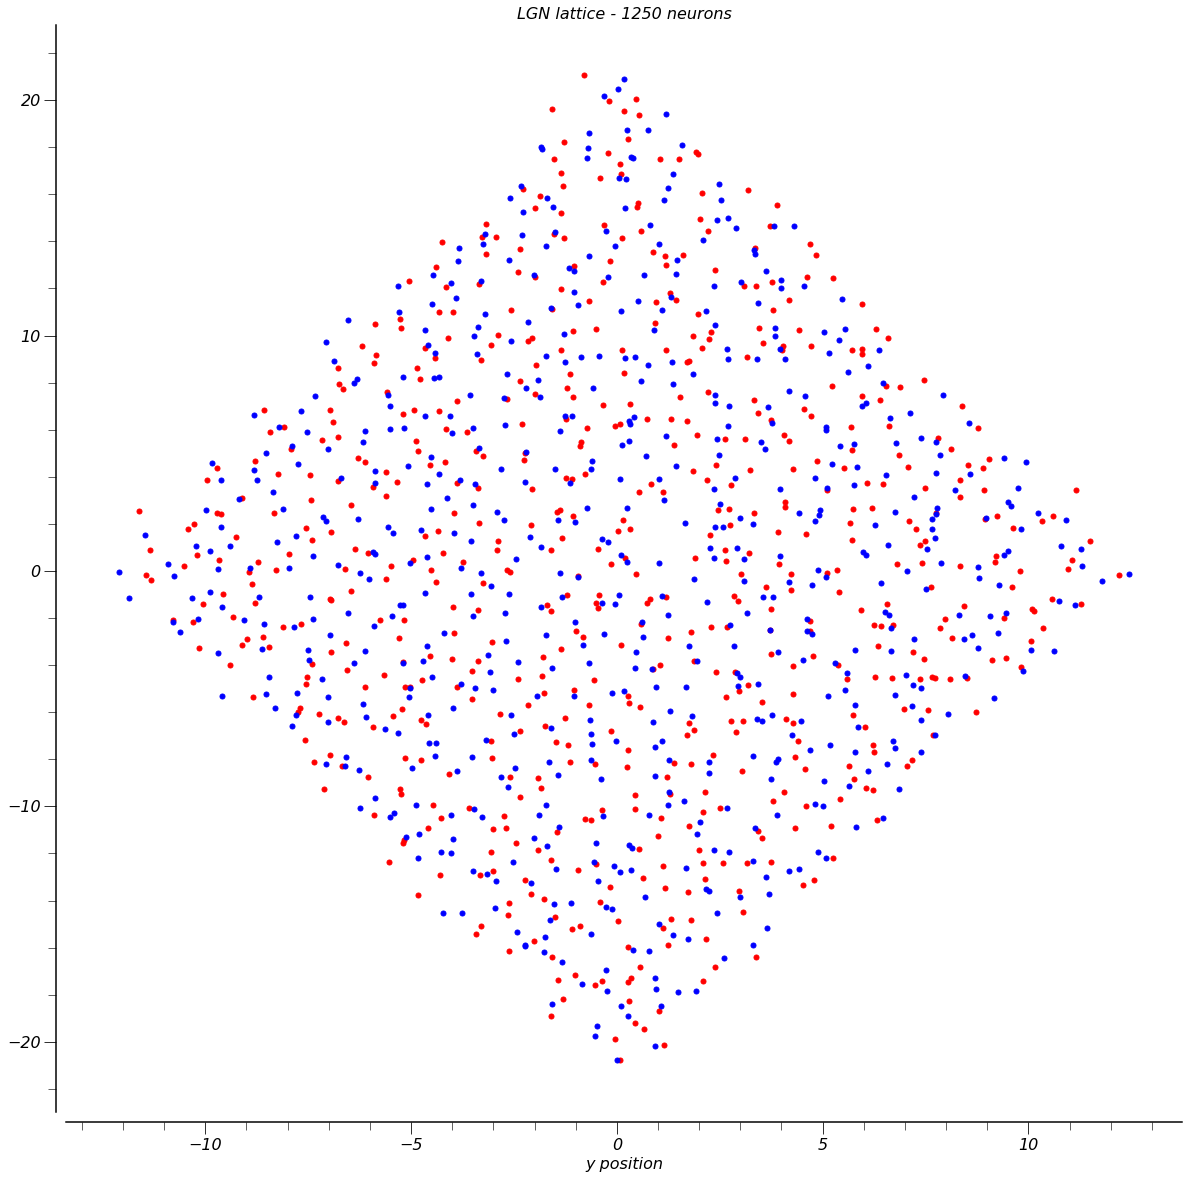

In [325]:
# now, let's plot
# -- by reducing the "alpha" of each point, it's visible which points have been resampled
#      simply because the multiple overlaid points will appear darker!

to_plt = 1;

if to_plt:
    fLGN = plt.figure(figsize=(20, 20))

for inds, lbl, clr in zip((on_inds, off_inds), ('on', 'off'), ('r', 'b')):

    # on or off?    
    if to_plt:
        if resamp_factor == 0: # i.e. no extra resampling done...so LGN is just RGC
            alph = 1;
        else: # we did sompe resampling, so make the points transparent to see overlay
            alph = 0.1;
        curr_locs = LGN_locs[inds]
        plt.scatter(curr_locs[:, 0], curr_locs[:, 1], c=clr, alpha=alph, label=lbl)

if to_plt:
    sns.despine(offset=10)
    plt.axis('equal');
    plt.axis('tight');
    plt.xlabel('x position')
    plt.xlabel('y position')
    plt.title('LGN lattice - %d neurons' % len(LGN_locs))
    # now, trim the figure so that we make it a square
#     plt.xlim([-np.minimum(10, nsteps)*lm, np.minimum(10, nsteps)*lm]);
#     plt.ylim([-np.minimum(10, nsteps)*lm, np.minimum(10, nsteps)*lm]);

### Now, draw LGN inputs for the V1 layer, and assign synaptic weights

"Next, we have to decide on the size of the RGC center. Wassle and co-workers have shown that the dendritic field radius is approximately the same as the mean nearest neighbor distance in the mosaic, which equals  0.76 . However, the physiological receptive field center is slightly larger than the actual dendritic tree, with the amplitude decaying to about 30% of its peak at the boundary of the dendritic tree (Peichl and Wassle 1983). To match this value, we selected the center of the RGC to be a two-dimensional Gaussian function with SD equal to $\sigma_{ctr} = 0.7 * \lambda$.

Then, probability of LGN (at $\vec{x}$) and V1 connection (at $\vec{y}$) is $p = p_{max} \exp(-\frac{{\mid{\vec{x}-\vec{y}}}\mid^2}{2\sigma_{conn}^2})$ where $\sigma_{conn} = 0.97*\sigma_{ctr}$ and $p_{max}=0.85$

In [326]:
autoreload.reload(lgn_v1)

<module 'lgn_v1' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/lgn_v1.py'>

In [353]:
exNum = exNum + 1;

v1_loc = None
lcs, stz, prms = lgn_v1.v1_cell(v1_loc=v1_loc, LGN_locs=LGN_locs, LGN_ids=LGN_ids)

### Sample the LGN fields, sum them up (with sign) to get the V1 field

In [354]:
n_samps = 1001;
bndsMult = 70;
prms['sig_ctr'] = 0.7; # default
# prms['sig_ctr'] = 0.95;
tot_field, sums, all_fields = lgn_v1.v1_sample(lcs, stz, prms, bndsMult=bndsMult, n_samps=n_samps)

#### Plot!

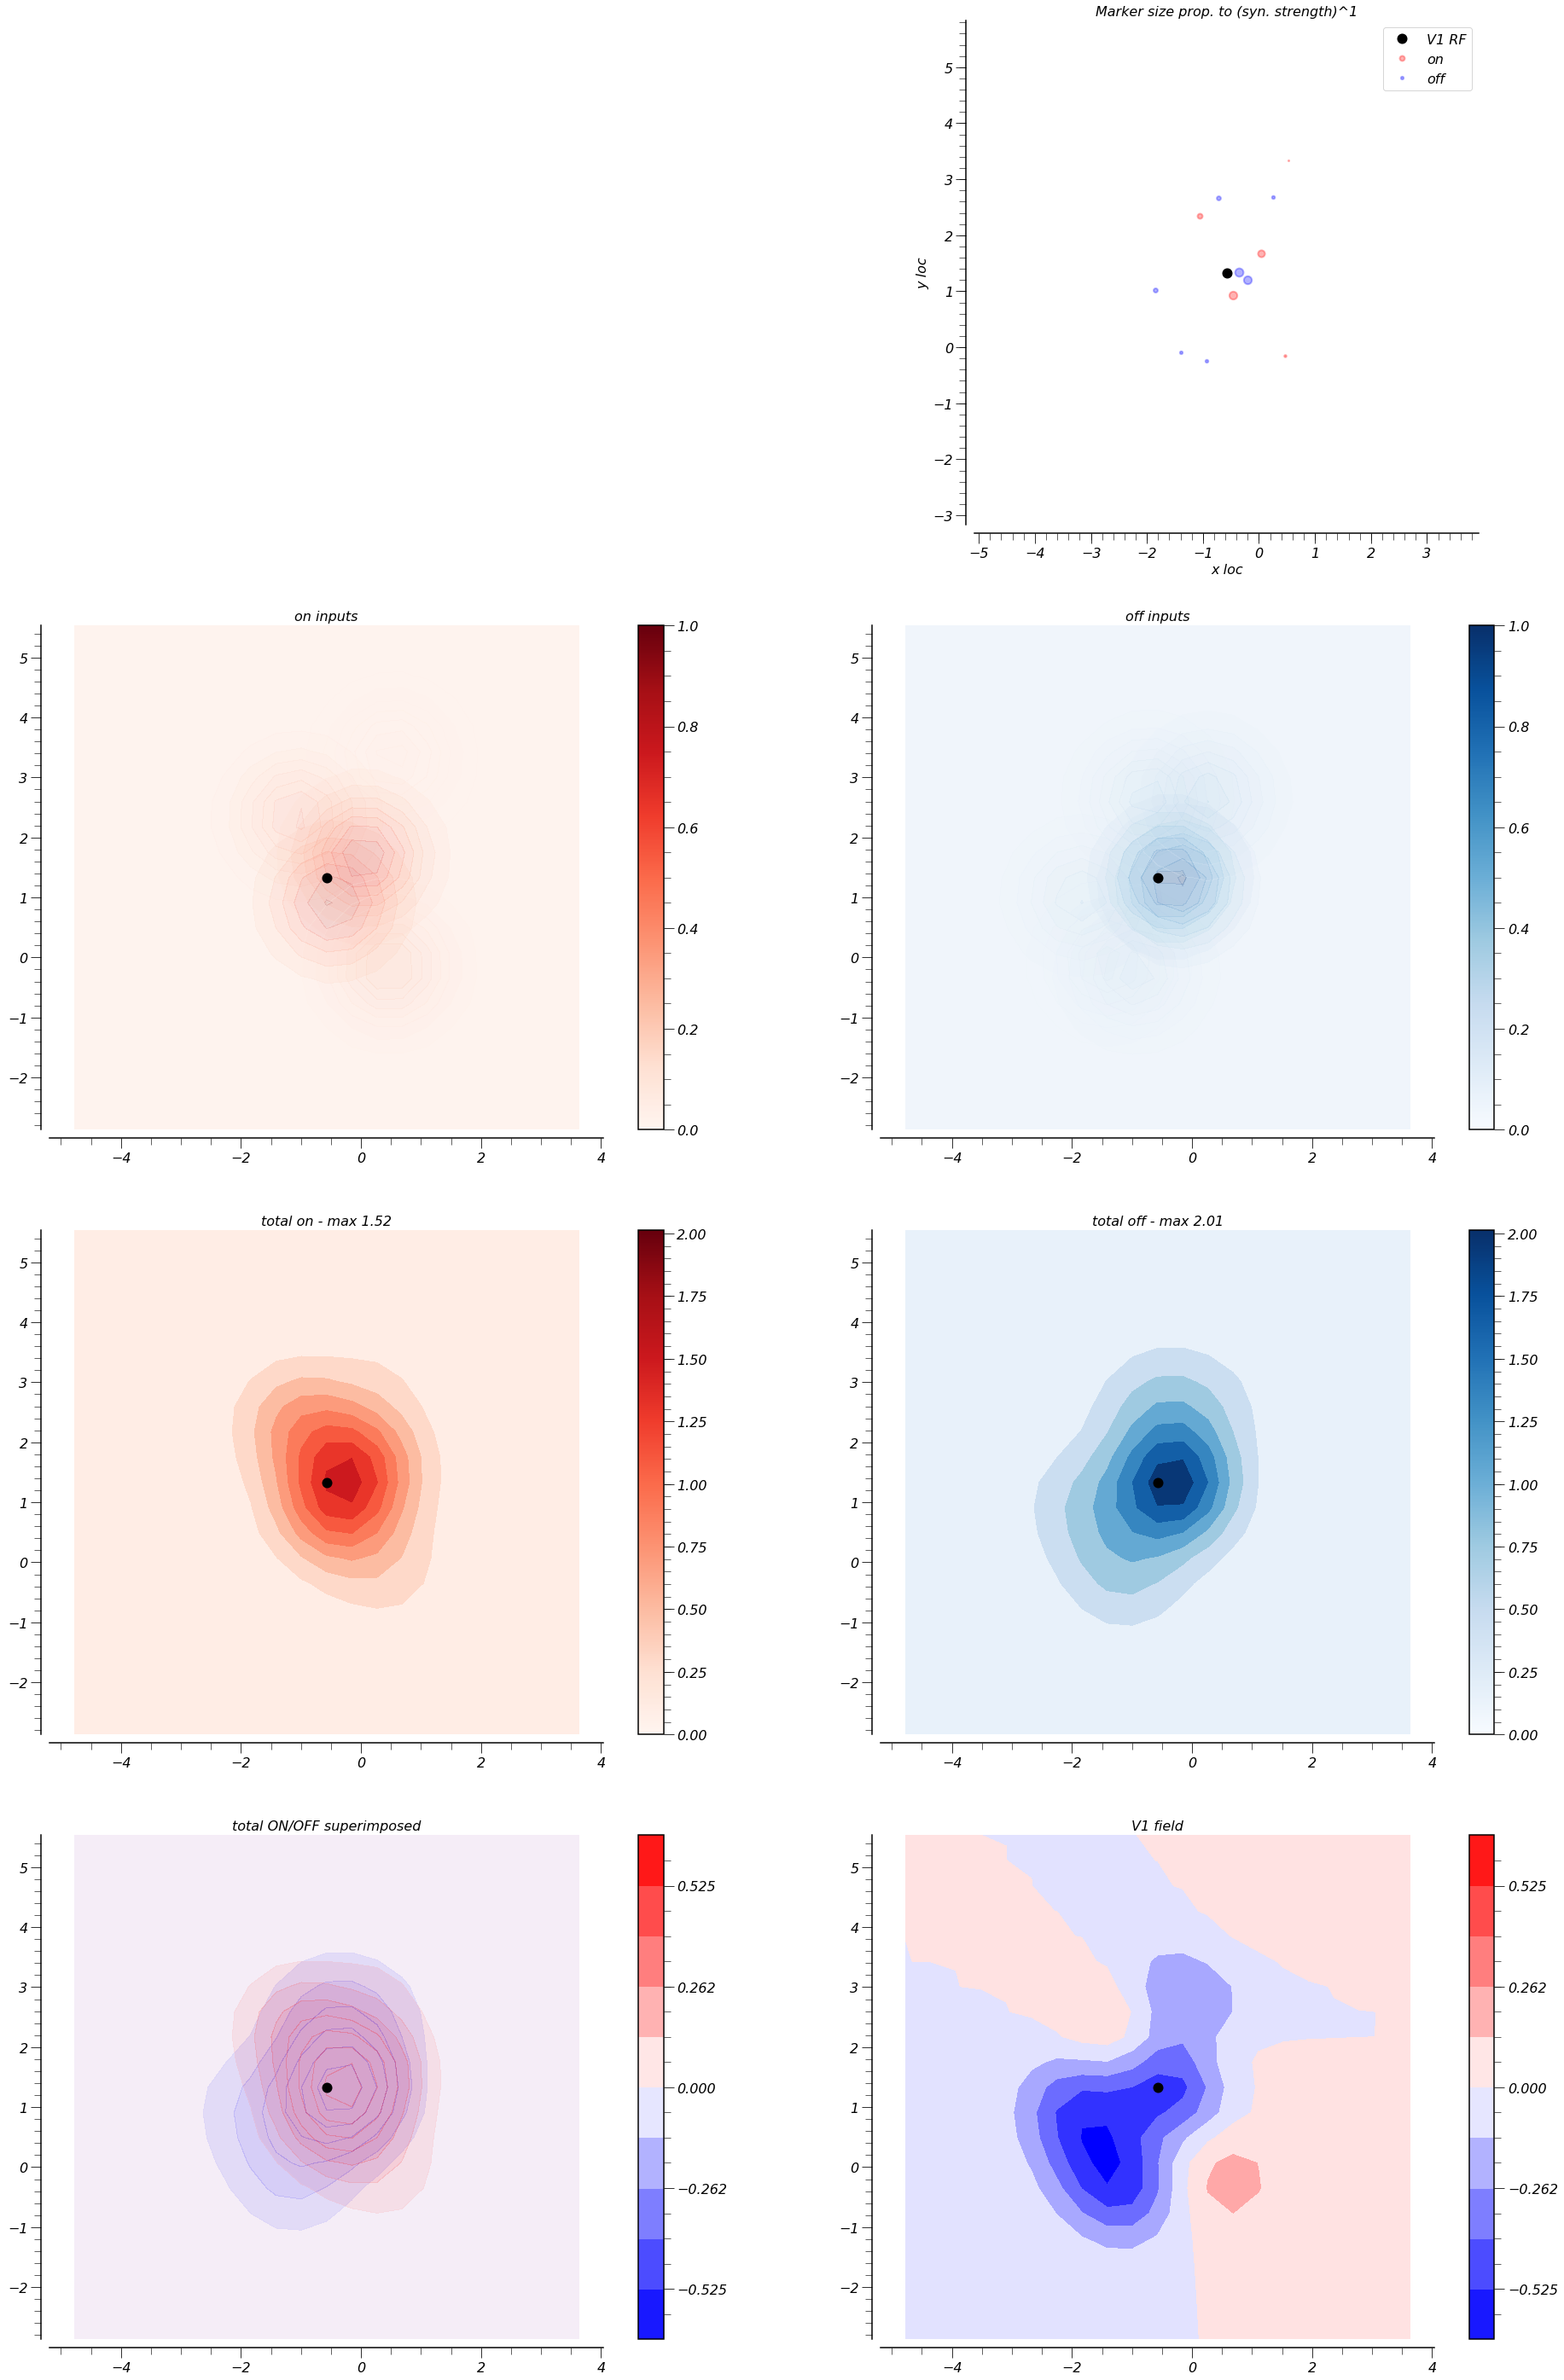

In [355]:
# quick aside: plot probability of connection as a function of calculated distance
# -- and which are actually connected

nrow, ncol = 4, 2
fConstr, ax = plt.subplots(nrow, ncol, figsize=(8*nrow, 25*ncol))

# some overall plot parameters, unpacking
v1_size = 10; # marker size for plot
v1_loc = prms['v1_loc']
near_thresh = prms['near_thresh']
bnds = near_thresh*bndsMult;
on_fields, off_fields = all_fields[0], all_fields[1];
on_sum, off_sum = sums[0], sums[1];

# # plot all possible connections and show which are made
ax[0, 0].axis('off')

# now, show the spatial location of these LGN fields relative to the V1 field
curr_on_locs = lcs[0]
curr_off_locs = lcs[1];
syn_wts = stz
clrs = ['r', 'b'];
lbls = ['on', 'off'];
ax[0, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
for lc, syn_wt, clr, lbl in zip(lcs, syn_wts, clrs, lbls):
    [ax[0, 1].plot(l[0], l[1], 'o', c=clr, label=lbl, alpha=0.3, markersize=v1_size*np.power(syn_w, 1)) for l,syn_w in zip(lc, syn_wt)];
ax[0, 1].set_xlabel('x loc');
ax[0, 1].set_ylabel('y loc');
ax[0, 1].axis('square');
xlims = [v1_loc[0]-1.5*near_thresh, v1_loc[0]+1.5*near_thresh];
ylims = [v1_loc[1]-1.5*near_thresh, v1_loc[1]+1.5*near_thresh];
ax[0, 1].set_xlim(xlims);
ax[0, 1].set_ylim(ylims);
ax[0, 1].legend();
ax[0, 1].set_title('Marker size prop. to (syn. strength)^1');

### and now, the real plotting
# - first, get the grid to sample
xs = np.linspace(-bnds, bnds, n_samps) + v1_loc[0];
ys = np.linspace(-bnds, bnds, n_samps) + v1_loc[1];
xcoor, ycoor = np.meshgrid(xs, ys);
all_coords = np.transpose(np.vstack((xcoor.ravel(), ycoor.ravel())));
# - then, what is the subsampled region we actually want to plot?
# -- why? we only evaluate and plot the wanted subset, rather than just put x/ylims on the plot, to reduce filesize
ok_x = np.logical_and(all_coords[:, 0] > xlims[0], all_coords[:, 0] < xlims[1])
ok_y = np.logical_and(all_coords[:, 1] > ylims[0], all_coords[:, 1] < ylims[1])
plt_inds = np.where(np.logical_and(ok_x, ok_y))
plt_xcoor = np.unique(all_coords[plt_inds, 0]);
plt_ycoor = np.unique(all_coords[plt_inds, 1]);

# first, ON
for i in range(len(on_fields)):
    curr_field = on_fields[i][plt_inds]
    curr_plt = np.reshape(curr_field, (len(plt_xcoor), len(plt_ycoor)));
    ax[1, 0].contourf(plt_xcoor, plt_ycoor, curr_plt, alpha=0.2, vmin = 0., vmax = 1., cmap=cm.Reds);
m = plt.cm.ScalarMappable(cmap=cm.Reds)
m.set_array(curr_plt)
m.set_clim(0, 1)
plt.colorbar(m, ax=ax[1, 0]);
ax[1, 0].set_title('on inputs')
    
# then, OFF
off_fields = all_fields[1];
for i in range(len(off_fields)):
    curr_field = off_fields[i][plt_inds];
    curr_plt = np.reshape(curr_field, (len(plt_xcoor), len(plt_ycoor)));
    ax[1, 1].contourf(plt_xcoor, plt_ycoor, curr_plt, alpha=0.2, vmin = 0., vmax = 1., cmap=cm.Blues);
m = plt.cm.ScalarMappable(cmap=cm.Blues)
m.set_array(curr_field)
m.set_clim(0, 1)
plt.colorbar(m, ax=ax[1, 1]);
ax[1, 1].set_title('off inputs')

# - then, which is stronger, overall - on or off?
mx_resp = np.maximum(np.max(on_sum), np.max(off_sum));

# --- on sum
on_plt = np.reshape(on_sum[plt_inds], (len(plt_xcoor), len(plt_ycoor)));
ax[2, 0].contourf(plt_xcoor, plt_ycoor, on_plt, vmin = 0, vmax = mx_resp, cmap=cm.Reds);
m = plt.cm.ScalarMappable(cmap=cm.Reds)
m.set_array(on_plt)
m.set_clim(0, mx_resp)
plt.colorbar(m, ax=ax[2, 0]);
ax[2, 0].set_title('total on - max %.2f' % np.max(on_sum))
    
# --- off sum
off_plt = np.reshape(off_sum[plt_inds], (len(plt_xcoor), len(plt_ycoor)));
ax[2, 1].contourf(plt_xcoor, plt_ycoor, off_plt, vmin = 0, vmax = mx_resp, cmap=cm.Blues);
m = plt.cm.ScalarMappable(cmap=cm.Blues)
m.set_array(off_plt)
m.set_clim(0, mx_resp)
plt.colorbar(m, ax=ax[2, 1]);
ax[2, 1].set_title('total off - max %.2f' % np.max(off_sum))

# NOW, get the full V1 field
v1_field = tot_field
v1_plot = np.reshape(v1_field[plt_inds], (len(plt_xcoor), len(plt_ycoor)));
mn, mx = np.min(v1_plot), np.max(v1_plot); mx_ab = np.maximum(np.abs(mn), np.abs(mx));
ax[3, 1].contourf(plt_xcoor, plt_ycoor, v1_plot, vmin = -mx_ab, vmax = mx_ab, cmap=cm.bwr);
ax[3, 1].set_title('V1 field')

m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(v1_plot)
m.set_clim(-mx_ab, mx_ab)
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[3, 1]);

# -- and the two (total ON/total OFF), superimposed
ax[3, 0].contourf(plt_xcoor, plt_ycoor, -off_plt, vmin = -mx_ab, alpha=0.2, vmax = mx_ab, cmap=cm.bwr);
ax[3, 0].contourf(plt_xcoor, plt_ycoor, on_plt, vmin = -mx_ab, alpha=0.2, vmax = mx_ab, cmap=cm.bwr);

### Finally, at the end: put the v1 location, make axis equal
for rw in range(nrow-1):
    ax[rw+1, 0].axis('equal');
    ax[rw+1, 1].axis('equal');
    ax[rw+1, 0].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
    ax[rw+1, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
    # - and set the limits
#     ax[rw+1, 0].set_xlim(xlims);
#     ax[rw+1, 0].set_ylim(ylims);
#     ax[rw+1, 1].set_xlim(xlims);
#     ax[rw+1, 1].set_ylim(ylims);


m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(v1_plot)
m.set_clim(-mx_ab, mx_ab)
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[3, 0]);
ax[3, 0].set_title('total ON/OFF superimposed')

sns.despine(offset=10)

### Finally, get the FT to analyze tuning and plot

In [356]:
arb_lgn_field = all_fields[0][0]; # identical fields, anyway
v1_ft, sf_tune, ori_tune, lgn_tune, v1_reconstruct = lgn_v1.analyze_filt(tot_field, arb_lgn_field, n_samps, bnds)

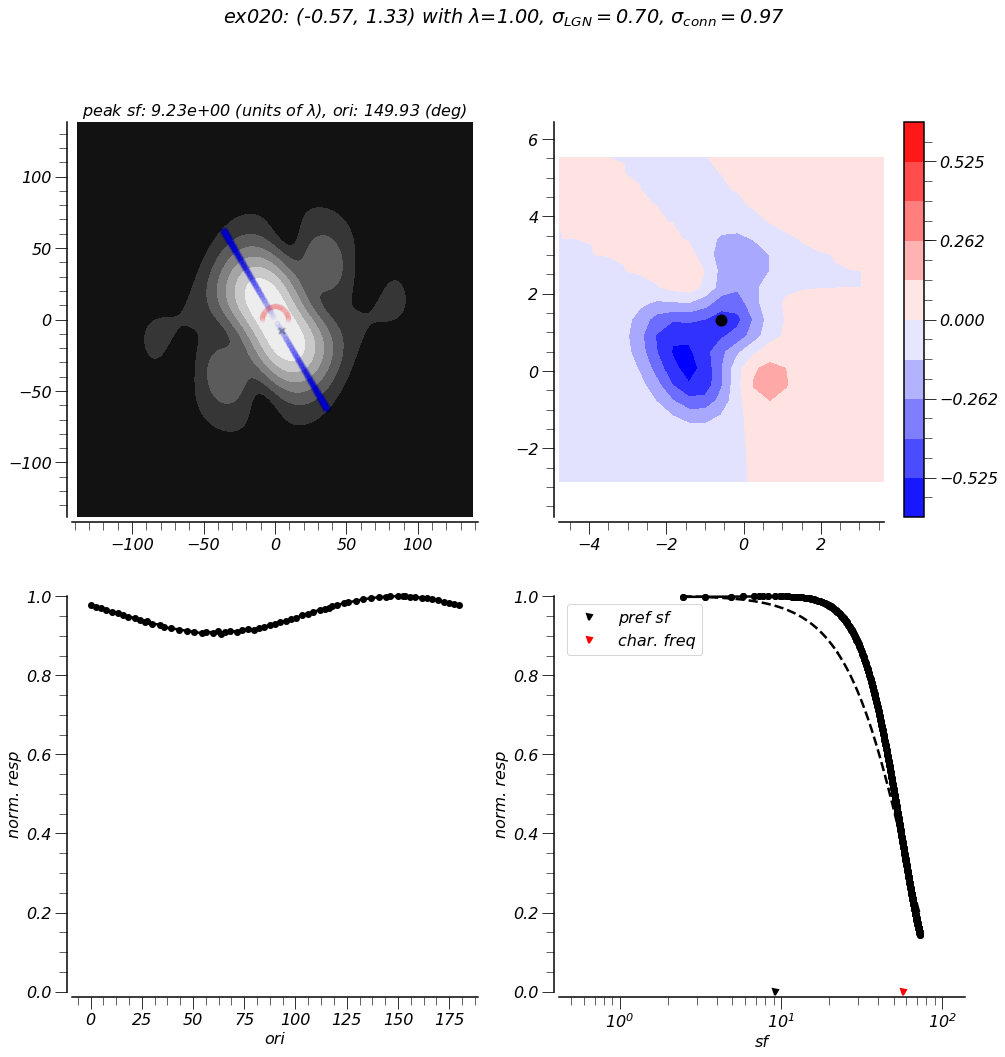

In [357]:
nr, nc = 2, 2;
fTune, ax = plt.subplots(nr, nc, figsize=(nc*8, nr*8))

### unpack
peak_sf = sf_tune['peak']
sf_curve = sf_tune['curve'];
sf_vals = sf_tune['sf_vals']
plt_oris = sf_tune['ori_vals']; # why? well, the SF tuning is evaluated at a particular orientation - which values?
peak_ori = ori_tune['peak'];
ori_curve = ori_tune['curve'];
ori_vals = ori_tune['ori_vals'];
plt_sfs = ori_tune['sf_vals']; # why? well, the ORI tuning is evaluated at a particular SF - which values?                                                                                                                                                                  
# -- and, don't forget, the LGN tuning!                                                                                                                                                                                                                                     
lgn_sf_vals = lgn_tune['sf_vals'];
lgn_curve = lgn_tune['curve'];
# -- and and, for the title
lm = prms['lmda'];
sig_ctr = prms['sig_ctr'];
sig_conn = prms['sig_conn'];

#####
### plot the Fourier representation of the filter
#####
# - and what frequencies?? well, [-n_samps/2, n_samps/2]*freq_scale
samp_step = np.round(2*bnds/n_samps, 3);
freq_scale = samp_step;
freqs = freq_scale*np.linspace(-(n_samps/2), n_samps/2, n_samps)
xfreq, yfreq = np.meshgrid(freqs, freqs);
# let's only evaluate and plot the wanted subset of frequencies (rather than just put x/ylims on the plot, to reduce filesize)
plt_bound = np.maximum(15*peak_sf, .4*freqs[-1]);
plt_fr = np.where(np.logical_and(freqs >= - plt_bound, freqs <= plt_bound))[0];
plt_xfr, plt_yfr = freqs[plt_fr], freqs[plt_fr];
plt_xc, plt_yc = np.meshgrid(plt_fr, plt_fr)
# -- then, get the 2d coordinates to index into v1_ft
plt_coords = np.transpose(np.vstack((plt_xc.ravel(), plt_yc.ravel())));
# -- bad python? access the right coords, but then it flattens, so then reshape into 2D again
plt_v1ft = np.reshape(v1_ft[plt_coords[:, 0], plt_coords[:, 1]], (len(plt_fr), len(plt_fr)));
ax[0, 0].contourf(plt_xfr, plt_yfr, plt_v1ft, cmap=cm.gray);
# ax[0, 0].contourf(xfreq, yfreq, v1_ft, cmap=cm.gray);
ax[0, 0].axis('equal');
## where is the peak of the filter?
filt_peak = np.argmax(v1_ft);
xmax, ymax = np.unravel_index(filt_peak, v1_ft.shape, order='C')
ax[0, 0].plot(freqs[xmax], freqs[ymax], 'kx', markersize=6, alpha=0.3)
# - cut the plot to zoom in on the relevant frequencies
ax[0, 0].set_title(r'peak sf: %.2e (units of $\lambda$), ori: %.2f (deg)' % (peak_sf, peak_ori))


#####
# What is the tuning? i.e. SF and ORI?
#####
#####
## NOW -- plot sf tuning measurements (fixed ori)
#####
[ax[0, 0].scatter(freqs[x], freqs[y], c='b', alpha=0.03) for x,y in [np.unravel_index(p, xcoor.shape, order='C') for p in plt_oris]]; # NOTE: xcoor/ycoor are same shape -- full grid of coordinates
xmin = samp_step; # don't plot any SF values below this
ax[1, 1].plot(np.maximum(peak_sf, samp_step), 0, 'kv', clip_on=False, label='pref sf')
# -- let's also compute the characteristic frequency (i.e. 1/e fall-off from peak)
fall_off = 1/np.exp(1); # 1/e
gt_peak = np.where(sf_vals > peak_sf)[0]; # only look at sfs greater than the peak
char_freq_ind = np.argmin(np.square(sf_curve[gt_peak] - fall_off));
char_freq = sf_vals[gt_peak[char_freq_ind]];
ax[1, 1].plot(np.minimum(char_freq, np.max(sf_vals)), 0, 'rv', clip_on=False, label='char. freq')
# -- now, let's plot the SF tuning curve
xmin = samp_step; # don't plot any SF values below this value
val_sfs = np.where(sf_vals>=xmin)
ax[1, 1].plot(sf_vals[val_sfs], np.divide(sf_curve[val_sfs], np.max(sf_curve)), 'k-o', clip_on=False)
ax[1, 1].set_xlabel('sf');
ax[1, 1].set_ylabel('norm. resp');
## -- and get the LGN filter tuning, too, at the same locations
ax[1, 1].plot(sf_vals[val_sfs], np.divide(lgn_curve[val_sfs], np.max(lgn_curve)), 'k--', clip_on=False)
ax[1, 1].set_xlim([xmin, plt_bound]);
ax[1, 1].set_ylim([0, 1]);
ax[1, 1].set_xscale('log')
ax[1, 1].legend();
#####
## THEN -- plot ori tuning measurements (fixed SF)
#####
[ax[0, 0].scatter(freqs[x], freqs[y], c='r', alpha=0.03) for x,y in [np.unravel_index(d, xcoor.shape, order='F') for d in plt_sfs]]
ax[1, 0].plot(ori_vals, np.divide(ori_curve, np.max(ori_curve)), 'k-o', clip_on=False)
ax[1, 0].set_xlabel('ori');
ax[1, 0].set_ylabel('norm. resp');
ax[1, 0].set_ylim([0, 1]);

#####
# --- show that we can reconstruct it back into the spatial domain
#####
# first, trim the reconstruction
v1_recon_flat = v1_reconstruct.ravel();
plt_v1_recon = v1_recon_flat[plt_inds]; # plt_inds is from above, as is plt_xcoor, plt_ycoor
curr_plt = np.reshape(plt_v1_recon, (len(plt_xcoor), len(plt_ycoor)));
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(curr_plt)
m.set_clim(-mx_ab, mx_ab)
ax[0, 1].contourf(plt_xcoor, plt_ycoor, curr_plt, vmin = -mx_ab, vmax = mx_ab, cmap=cm.bwr);
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[0, 1]);
ax[0, 1].axis('equal');
# ax[0, 1].set_xlim(xlims);
# ax[0, 1].set_ylim(ylims);
ax[0, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');

sns.despine(offset=5)

# make overall title
fTune.suptitle(r'ex%03d: (%.2f, %.2f) with $\lambda$=%.2f, $\sigma_{LGN}=%.2f$, $\sigma_{conn}=%.2f$' % (exNum, v1_loc[0], v1_loc[1], lm, sig_ctr, sig_conn));


In [358]:
#####
# now, combine and save
#####
f_exCell = [fConstr, fTune];
plt_label = ['_constr', '_tune'];
nm_base = 'lat%03d_ex%03d' % (latNum, exNum);
curr_name = '%s_v1_LGN_%03d.pdf' % (nm_base, 100*sig_ctr)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
if not os.path.exists(save_loc + 'pdf_orig/'):
    os.makedirs(save_loc + 'pdf_orig/')
if not os.path.exists(save_loc + '%s/' % nm_base):
    os.makedirs(save_loc + '%s/' % nm_base)
pdfSv = pltSave.PdfPages(save_loc + 'pdf_orig/' + curr_name);
for fc, lbl in zip(f_exCell, plt_label):
    # first, save png of just the one figure
    fc.savefig(save_loc + nm_base + '/'  + curr_name.replace('.pdf', '%s.png' % lbl));
    # then, add to the pdf
    pdfSv.savefig(fc, dpi=5)
    plt.close(fc)
pdfSv.close()

# Analyzing VNL's LGN database
Let's create an example M and P cell at the front of our V1 model. But first, let's analyze the VNL database of LGN neurons (from previous experiments) to determine what LGN parameters would summarize the M and P populations at our particular eccentricity range
We'll also use my data/Sach's data to help with this, especially for the RVC function.

In [684]:
save_loc = base_dir + 'figures/reports/lgn_v1_200719/'

In [685]:
lgn_csv = 'lgn-vnl-database-cut.xls'
lgn_db = pd.read_excel(lgn_csv)

According to the original xls sheet, rows B3:B97 are Magno; B98:B216 are Parvo (Note that those rows include the two "header" rows, so we'll adjust accordingly

In [686]:
magno_rows = np.arange(3-3, 97-3+1) # we sub 3 (2+1) to account for removal of the header rows and zero-indexing here in python
parvo_rows = np.arange(98-3, 216-3+1) # and we add back 1 on the edge to ensure we include the last row

First, let's ignore eccentricity and just plot the fc across classes; then, we'll just take cells within a specified ecc. range

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


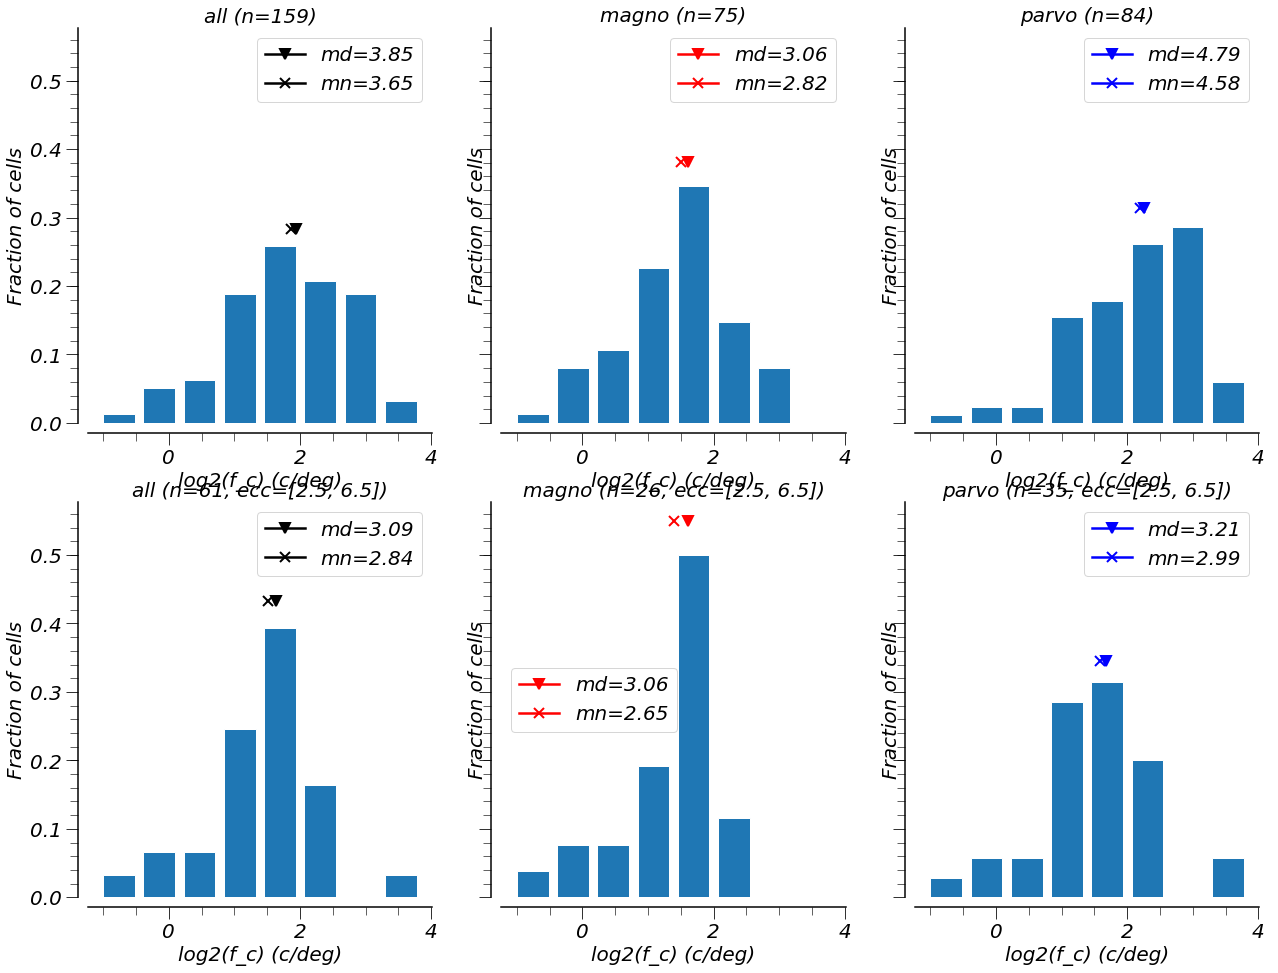

In [687]:
ecc_range = [2.5, 6.5];
nSteps = 9;
fc_bins = np.geomspace(0.5, 15, nSteps);

width = 0.3*np.ptp(fc_bins)/nSteps # ptp is np.max - np.min

# just loss
nrow, ncol = 2, 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 8*nrow), sharey=True)

inds = [np.arange(0, len(lgn_db['fc'])), magno_rows, parvo_rows]
lbls = ['all', 'magno', 'parvo']
clrs = ['k', 'r', 'b']

# first, across all ecc.
for ii, (ind_curr, lbl, clr) in enumerate(zip(inds, lbls, clrs)):
    all_fc = hf.nan_rm(lgn_db['fc'][ind_curr]);
    all_fc_clip = np.clip(all_fc, fc_bins[0], fc_bins[-1])
    counts, _ = np.histogram(all_fc_clip, bins=fc_bins)
    counts_norm = counts/len(all_fc_clip)
    ax[0, ii].bar(np.log2(fc_bins[0:-1]), counts_norm, width=width, align='edge')
    ax[0, ii].set_ylabel('Fraction of cells');
    ax[0, ii].set_xlabel('log2(f_c) (c/deg)')
    ax[0, ii].set_title('%s (n=%d)' % (lbl, len(all_fc)));
    median = np.nanmedian(np.log2(all_fc));
    ax[0, ii].plot(median, 1.1*np.max(counts_norm), marker='v', linestyle=None, color=clr, markersize=10, label='md=%.2f' % np.power(2, median))
    mean = np.nanmean(np.log2(all_fc));
    ax[0, ii].plot(mean, 1.1*np.max(counts_norm), marker='x', linestyle=None, color=clr, markersize=10, label='mn=%.2f' % np.power(2, mean));
    ax[0, ii].legend();

# then, restricted!
ecc_ok = np.where(np.logical_and(lgn_db['ecc'] >= ecc_range[0], lgn_db['ecc'] <= ecc_range[1]))[0];
inds_restrict = [np.intersect1d(ind, ecc_ok) for ind in inds];

for ii, (ind_curr, lbl, clr) in enumerate(zip(inds_restrict, lbls, clrs)):
    all_fc = hf.nan_rm(lgn_db['fc'][ind_curr]);
    all_fc_clip = np.clip(all_fc, fc_bins[0], fc_bins[-1])
    counts, _ = np.histogram(all_fc_clip, bins=fc_bins)
    counts_norm = counts/len(all_fc_clip)
    ax[1, ii].bar(np.log2(fc_bins[0:-1]), counts_norm, width=width, align='edge')
    ax[1, ii].set_ylabel('Fraction of cells');
    ax[1, ii].set_xlabel('log2(f_c) (c/deg)')
    ax[1, ii].set_title('%s (n=%d, ecc=[%.1f, %.1f])' % (lbl, len(all_fc), ecc_range[0], ecc_range[1]));
    median = np.nanmedian(np.log2(all_fc));
    ax[1, ii].plot(median, 1.1*np.max(counts_norm), marker='v', linestyle=None, color=clr, markersize=10, label='md=%.2f' % np.power(2,median))
    mean = np.nanmean(np.log2(all_fc));
    ax[1, ii].plot(mean, 1.1*np.max(counts_norm), marker='x', linestyle=None, color=clr, markersize=10, label='mn=%.2f' % np.power(2, mean))
    ax[1, ii].legend();
    
sns.despine(offset=10)

In [688]:
# what about another metric besides fc? How about ks (the relative sensitivity of the surround)

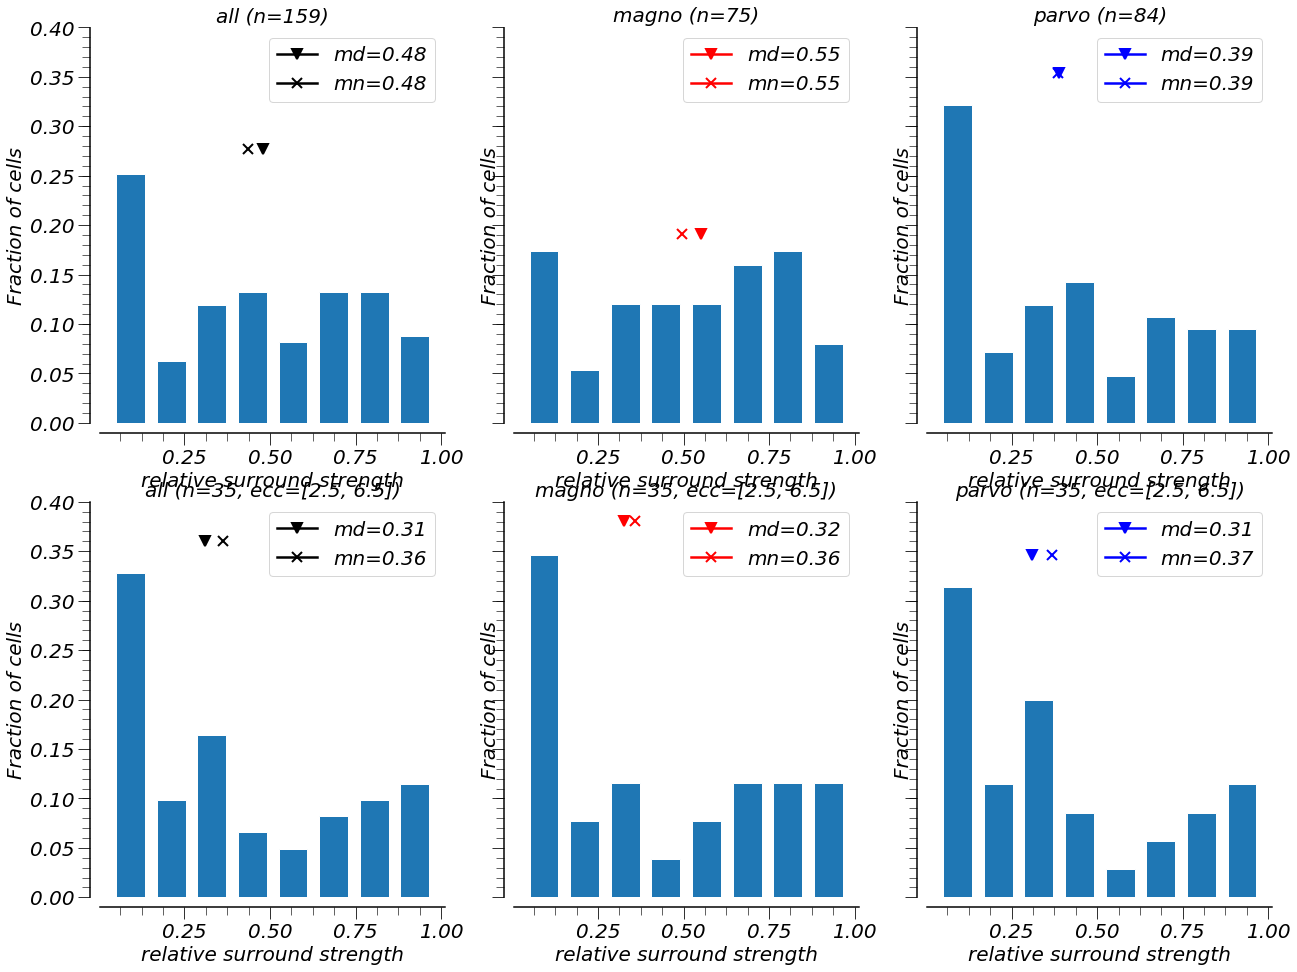

In [689]:
ecc_range = [2.5, 6.5];
nSteps = 9;
ks_bins = np.linspace(0.05, 1, nSteps);

width = 0.8*np.ptp(ks_bins)/nSteps # ptp is np.max - np.min

# just loss
nrow, ncol = 2, 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 8*nrow), sharey=True)

inds = [np.arange(0, len(lgn_db['fc'])), magno_rows, parvo_rows]
lbls = ['all', 'magno', 'parvo']
clrs = ['k', 'r', 'b']

# first, across all ecc.
for ii, (ind_curr, lbl, clr) in enumerate(zip(inds, lbls, clrs)):
    all_ks = hf.nan_rm(lgn_db['ks'][ind_curr]);
    all_ks_clip = np.clip(all_ks, ks_bins[0], ks_bins[-1])
    counts, _ = np.histogram(all_ks_clip, bins=ks_bins)
    counts_norm = counts/len(all_ks_clip)
    ax[0, ii].bar(ks_bins[0:-1], counts_norm, width=width, align='edge')
    ax[0, ii].set_ylabel('Fraction of cells');
    ax[0, ii].set_xlabel('relative surround strength')
    ax[0, ii].set_title('%s (n=%d)' % (lbl, len(all_ks)));
    median = np.nanmedian(all_ks);
    ax[0, ii].plot(median, 1.1*np.max(counts_norm), marker='v', linestyle=None, color=clr, markersize=10, label='md=%.2f' % median)
    mean = np.nanmean(all_ks);
    ax[0, ii].plot(mean, 1.1*np.max(counts_norm), marker='x', linestyle=None, color=clr, markersize=10, label='mn=%.2f' % median)
    ax[0, ii].legend();

# then, restricted!
ecc_ok = np.where(np.logical_and(lgn_db['ecc'] >= ecc_range[0], lgn_db['ecc'] <= ecc_range[1]))[0];
inds_restrict = [np.intersect1d(ind, ecc_ok) for ind in inds];

for ii, (ind_curr, lbl, clr) in enumerate(zip(inds_restrict, lbls, clrs)):
    all_ks = hf.nan_rm(lgn_db['ks'][ind_curr]);
    all_ks_clip = np.clip(all_ks, ks_bins[0], ks_bins[-1])
    counts, _ = np.histogram(all_ks_clip, bins=ks_bins)
    counts_norm = counts/len(all_ks_clip)
    ax[1, ii].bar(ks_bins[0:-1], counts_norm, width=width, align='edge')
    ax[1, ii].set_ylabel('Fraction of cells');
    ax[1, ii].set_xlabel('relative surround strength')
    ax[1, ii].set_title('%s (n=%d, ecc=[%.1f, %.1f])' % (lbl, len(all_fc), ecc_range[0], ecc_range[1]));
    median = np.nanmedian(all_ks);
    ax[1, ii].plot(median, 1.1*np.max(counts_norm), marker='v', linestyle=None, color=clr, markersize=10, label='md=%.2f' % median)
    mean = np.nanmean(all_ks);
    ax[1, ii].plot(mean, 1.1*np.max(counts_norm), marker='x', linestyle=None, color=clr, markersize=10, label='mn=%.2f' % mean)
    ax[1, ii].legend();
    
sns.despine(offset=10)

# Population tuning curves

Per Tony: One way to get insight into this would be to analyze the pooled
single-grating responses of *all* your cortical cells (or maybe all the
cells within an eccentricity range that ran the same conditions). If the
M -> P shift is correct, then this combined population tuning should
show characteristic changes. In particular the SF tuning should shift
with contrast because the M input should dominate the population at low
contrast, while the P input dominates at high. Equivalently, the
population RvC functions should change shape as you go from the M to the
P range. Easy enough to do, I think -- just throw all your spikes into
one big bucket and do some fits.

We can do the analysis from the jointList structure

In [1270]:
jl_name = 'jointList_V1_200610_vT70_dvT60.npy'
jl = np.load(base_dir + jl_name)

In [1271]:
# For now, we'll exclude the V1_orig/ data, since it doesn't have the range of contrasts that we want to use
excl = 'V1_orig/';

In [1272]:
# First, let's construct the full matrix of data to be filled...
nCells = len(jl);

all_sf, all_con = np.array([]), np.array([]);
sfEq_tol = 2; # round SF values to nearest hundreth before testing equality

for nC in range(nCells):
    
    if excl in jl[nC]['metadata']['fullPath']:
        continue; # skip this cell
        
    # SINGLE GRATINGS ONLY
    curr_byDisp = jl[nC]['metadata']['val_con_by_disp'];
    curr_stim = jl[nC]['metadata']['stimVals'];
    curr_sf  = curr_stim[2];
    curr_con = curr_stim[1][curr_byDisp[0]];
    
    all_sf = np.unique(np.hstack((all_sf, np.round(curr_sf, sfEq_tol))))
    all_con = np.unique(np.hstack((all_con, curr_con)))

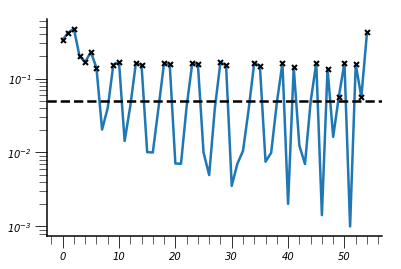

In [1180]:
### Annoying interlude - get rid of values very close to one another 
diffs = np.diff(all_sf)
diffs_norm = np.divide(diffs, all_sf[0:-1]);
plt.semilogy(diffs_norm);
ok_frac = 5e-2;
plt.axhline(ok_frac, color='k', ls='--')

# so, if the diff (normalized by adjacent (1-back) SF) is less than ok_frac, then we'll consider them equal...
frac_pass = np.where(diffs_norm>ok_frac)[0];
all_sf_pass = np.hstack((all_sf[0], all_sf[1+frac_pass]))

plt.semilogy(frac_pass, diffs_norm[frac_pass], 'kx')

In [1304]:
### now, with our reduced set of SFS, let's go through and populate 

#######
# Rules for populating
force_dc = False; # force DC?
excl_simple = False;
excl_complex = False;

save_loc = base_dir + 'figures/reports/lgn_v1_200722/'
#######

# NOW - full matrix of responses
nSf, nCon = len(all_sf_pass), len(all_con)
sum_resp = np.zeros((nSf, nCon));
sum_var = np.zeros((nSf, nCon));
num_resp = np.zeros((nSf, nCon));

dataList = None;
ref_path = None;

for nC in range(nCells):
    
    if excl in jl[nC]['metadata']['fullPath']:
        continue; # skip this cell

    # load the cell
    curr_path = jl[nC]['metadata']['fullPath'];
    which_cell = jl[nC]['metadata']['cellNum']; # which cell - index will be which_cell - 1
    if dataList is None or curr_path != ref_path:
        ref_path = curr_path; # update ref_path
        dataList = hf.np_smart_load(ref_path + jl[nC]['metadata']['dataList'])
        rvcFits = hf.np_smart_load(ref_path + jl[nC]['metadata']['rvcFits'])

    cellName = dataList['unitName'][which_cell-1];
    expInd = hf.get_exp_ind(ref_path, cellName)[0]
    S = hf.np_smart_load(ref_path + cellName + '_sfm.npy')
    expData = S['sfm']['exp']['trial'];

    # get the stimulus info
    curr_byDisp = jl[nC]['metadata']['val_con_by_disp'];
    curr_stim = jl[nC]['metadata']['stimVals'];
    curr_sf  = curr_stim[2];
    curr_conInds = curr_byDisp[0];
    curr_con = curr_stim[1][curr_conInds];
    
    # first, compute f1f0 ratio to determine if we look at f0 or f1 response
    f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, ref_path, descrFitName_f0=None)[0];      

    if excl_simple and f1f0_rat>1:
        continue; # i.e. skip simple cells
    if excl_complex and f1f0_rat<1:
        continue; # i.e. skip complex cells
    
    rvcCurr = rvcFits[which_cell-1];
    
    # get the spikes
    spikes = hf.get_adjusted_spikerate(expData, which_cell-1, expInd, ref_path, rvcName=rvcFits, rvcMod=-1, descrFitName_f0=None, baseline_sub=True, force_dc=force_dc);
  
    _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
    resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=True);
    predResps = resps[2];

    respMean = resps[0]; # equivalent to resps[0];
    respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition
    respVar = np.square(respStd);
    
    # get the right conditions and put them in the right place...
    closest_sfInds = [np.argmin(np.square(np.log2(all_sf_pass) - np.log2(x))) for x in curr_sf]
    # -- cons are exact, but w/e...
    closest_conInds = [np.argmin(np.square(np.log2(all_con) - np.log2(x))) for x in curr_con]
    
    for ii, ccI in enumerate(curr_conInds):
        sum_resp[closest_sfInds, closest_conInds[ii]] += respMean[0, :, ccI];
        sum_var[closest_sfInds, closest_conInds[ii]] += respVar[0, :, ccI];
        num_resp[closest_sfInds, closest_conInds[ii]] += 1;
    
    

### Now, plot!

In [1305]:
# for sf, rvc fits
dogMod = 0; # using flex. gauss for fitting
lossType = 1;
nOpts = 10;
showFitSf = 0;
# - rvc
rvcMod = 1; # 0 (Mov); 1 (NR); 2 (Peirce)
if rvcMod == 0:
    rvcSuff = '';
elif rvcMod == 1:
    rvcSuff = '_NR';
elif rvcMod == 2:
    rvcSuff = '_Peirce';
nOptRVC = 25;
showFitRVC = 1;

# Bounds for fitting flexGauss...
max_resp = 100;
if dogMod == 0: # FLEX - flexible gaussian (i.e. two halves)                                                                                                                                                                                                              
    min_bw = 1/4; max_bw = 10; # ranges in octave bandwidth                                                                                                                                                                                                                   
    bound_baseline = (0, max_resp);
    bound_range = (0, 1.5*max_resp);
    bound_mu = (0.01, 10);
    bound_sig = (np.maximum(0.1, min_bw/(2*np.sqrt(2*np.log(2)))), max_bw/(2*np.sqrt(2*np.log(2)))); # Gaussian at half-height                                                                                                                                                
    allBounds = (bound_baseline, bound_range, bound_mu, bound_sig, bound_sig);

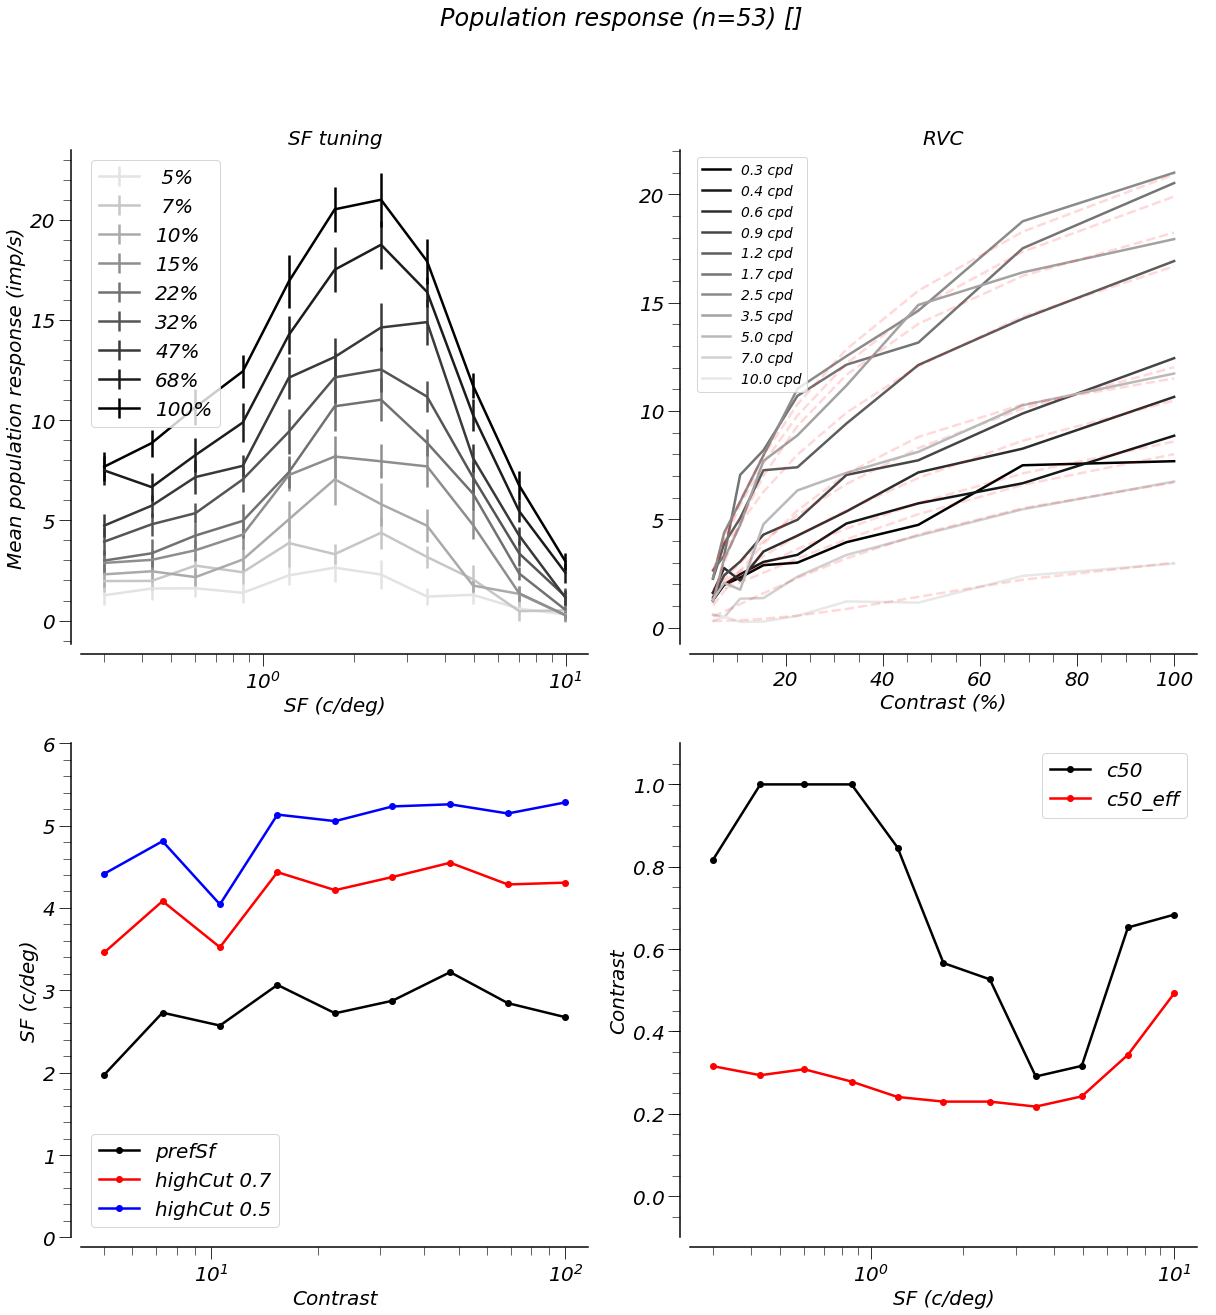

In [1306]:
nThresh = 15; # only plot conditions that have more than nThresh cells contributing

nRow, nCol = 2, 2;
f, ax = plt.subplots(nRow, nCol, figsize=(nCol*10, nRow*10))

passSfs, passCons = np.where(num_resp
                             >nThresh);

### FIRST, SF TUNING
uniqueConInds = np.unique(passCons);
peakSfs = np.nan * np.empty((len(uniqueConInds)), )
sfFrac = 0.7; # what percentage fall-off to track?
sfFracHalf = 0.5; # what percentage fall-off to track?
sfHighcut = np.nan * np.empty((len(uniqueConInds)), )
sfHighcutHalf = np.nan * np.empty((len(uniqueConInds)), )

# NOTE: iCon and uC should be the same, but doing this just to be safe (in case there are skips in uniqueConInds)
for iCon, uC in enumerate(uniqueConInds):
    curr_inds = np.where(passCons == uC);
    curr_sfInds = passSfs[curr_inds];
    
    curr_sf, curr_con = all_sf_pass[curr_sfInds], all_con[uC];
    curr_resp = sum_resp[curr_sfInds, iCon];
    curr_var = sum_var[curr_sfInds, iCon];
    curr_nResp = num_resp[curr_sfInds, iCon];

    # color
    nConPlt = float(len(uniqueConInds));
    col = [(nConPlt-1-iCon)/nConPlt, (nConPlt-1-iCon)/nConPlt, (nConPlt-1-iCon)/nConPlt];
    
    normResp = np.divide(curr_resp, curr_nResp);
    normVar = np.divide(np.sqrt(curr_var), curr_nResp);

    best_prms, best_fit = None, None;
    for i in range(nOpts):
        init_params = hf.dog_init_params(normResp, base_rate=np.min(normResp), all_sfs=curr_sfInds, valSfVals=curr_sf, DoGmodel=dogMod)
        obj = lambda params: hf.DoG_loss(params, normResp, curr_sf, loss_type=lossType, DoGmodel=dogMod, resps_std=normVar)
        wax = opt.minimize(obj, init_params, bounds=allBounds);
        if best_fit is None or wax['fun'] < best_fit:
            best_fit = wax['fun'];
            best_prms = wax['x'];
    
    ax[0,0].errorbar(curr_sf, normResp, normVar, color=col, label='%2d%%' % (curr_con*100))
    if showFitSf == 1:
        ax[0,0].plot(curr_sf, hf.get_descrResp(best_prms, curr_sf, dogMod), 'r--', alpha=curr_con)

    # Save peak SF, 70% cut-off
    peakSfs[iCon] = hf.descr_prefSf(best_prms, dog_model=dogMod);
    sfHighcut[iCon] = hf.sf_highCut(best_prms, sfMod=dogMod, frac=sfFrac, sfRange=(0.1, 15), baseline_sub=None);
    sfHighcutHalf[iCon] = hf.sf_highCut(best_prms, sfMod=dogMod, frac=sfFracHalf, sfRange=(0.1, 15), baseline_sub=None);

ax[0,0].set_xscale('log')
ax[0,0].set_ylabel('Mean population response (imp/s)');
ax[0,0].set_xlabel('SF (c/deg)');
ax[0,0].legend();
ax[0,0].set_title('SF tuning')

# now, plot the prefSf, sfHigh cut as f'n of contrast
ax[1,0].semilogx(100*all_con, peakSfs, 'k-o', label='prefSf')
ax[1,0].semilogx(100*all_con, sfHighcut, 'r-o', label='highCut %.1f' % sfFrac)
ax[1,0].semilogx(100*all_con, sfHighcutHalf, 'b-o', label='highCut %.1f' % sfFracHalf)
ax[1,0].set_xlabel('Contrast');
ax[1,0].set_ylabel('SF (c/deg)');
ax[1,0].set_ylim([0, 6])
ax[1,0].legend();

### Then, RVC
uniqueSfInds = np.unique(passSfs);

fitC50 = np.nan * np.empty((len(uniqueSfInds)), )
fitC50_eval = np.nan * np.empty((len(uniqueSfInds)), )

for iSf, uSf in enumerate(uniqueSfInds):
    curr_inds = np.where(passSfs == uSf)[0];
    curr_conInds = passCons[curr_inds];
    
    curr_sf, curr_cons = all_sf_pass[uSf], all_con[curr_conInds];
    curr_resp = sum_resp[uSf, curr_conInds];
    curr_var = sum_var[uSf, curr_conInds];
    curr_nResp = num_resp[uSf, curr_conInds];
    
    normResp = np.divide(curr_resp, curr_nResp);
    normVar = np.divide(np.sqrt(curr_var), curr_nResp);
    
    # color
    nSfsPlt = float(len(uniqueSfInds));
    col = [iSf/nSfsPlt, iSf/nSfsPlt, iSf/nSfsPlt];
    
    fit = hf.rvc_fit([normResp], [curr_cons], [normVar], mod=rvcMod, n_repeats=nOptRVC)[1][0]; # return [1], get the (one and only) fit with [0]
        
    ax[0,1].plot(curr_cons*100, normResp, color=col, label='%.1f cpd' % (curr_sf))
    if showFitRVC == 1:
        rvcModResp = hf.get_rvcResp(fit, curr_cons, rvcMod);
        ax[0,1].plot(curr_cons*100, rvcModResp, 'r--', alpha=0.15)
    
    fitC50[iSf] = hf.get_c50(rvcMod, fit);
    fitC50_eval[iSf] = hf.c50_empirical(rvcMod, fit)[1];
    
ax[0,1].set_xlabel('Contrast (%)')
ax[0,1].legend(fontsize='x-small');
ax[0,1].set_title('RVC')

# now, plot the c50, c50_eff as f'n of SF
ax[1,1].semilogx(all_sf_pass[uniqueSfInds], fitC50, 'k-o', label='c50')
ax[1,1].semilogx(all_sf_pass[uniqueSfInds], fitC50_eval, 'r-o', label='c50_eff')
ax[1,1].set_ylabel('Contrast');
ax[1,1].set_xlabel('SF (c/deg)');
ax[1,1].set_ylim([-0.1, 1.1])
ax[1,1].legend();


sns.despine(offset=10)

## Now, save
dc_suffix = '';
simp_suffix = '';
comp_suffix = '';
if force_dc == True:
    dc_suffix = '_dc';
if excl_simple == True:
    comp_suffix = '_complex';
if excl_complex == True:
    simp_suffix = '_simple';

nCls = np.unique(num_resp[passSfs, passCons])[0];
f.suptitle('Population response (n=%d) [%s%s%s]' % (nCls, dc_suffix, comp_suffix, simp_suffix))
    
saveName = 'pop_resp%s%s%s%s.pdf' % (dc_suffix, comp_suffix, simp_suffix, rvcSuff)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### Quick check: Do these results line up with what we see from individual fits?

For example, there's a striking difference between the peak SF of complex cells and simple cells. Let's check that in the distribution of individual fits

In [1269]:
# First, let's construct the full matrix of data to be filled...
nCells = len(jl);

prefSf, sf70, f1f0 = [],[],[];
sfEq_tol = 2; # round SF values to nearest hundreth before testing equality

for nC in range(nCells):
    
    if excl in jl[nC]['metadata']['fullPath']:
        continue; # skip this cell
        
    '''
    # SINGLE GRATINGS ONLY - to use later
    curr_byDisp = jl[nC]['metadata']['val_con_by_disp'];
    curr_stim = jl[nC]['metadata']['stimVals'];
    curr_sf  = curr_stim[2];
    curr_con = curr_stim[1][curr_byDisp[0]];
    '''
    
    f1f0.append(jl[nC]['metrics']['f1f0_ratio']);
    prefSf.append(jl[nC]['metrics']['pSf'][0,-1]);
    sf70.append(jl[nC]['metrics']['sf70'][0,-1]);

f1f0 = np.array(f1f0);
prefSf = np.array(prefSf);
sf70 = np.array(sf70);

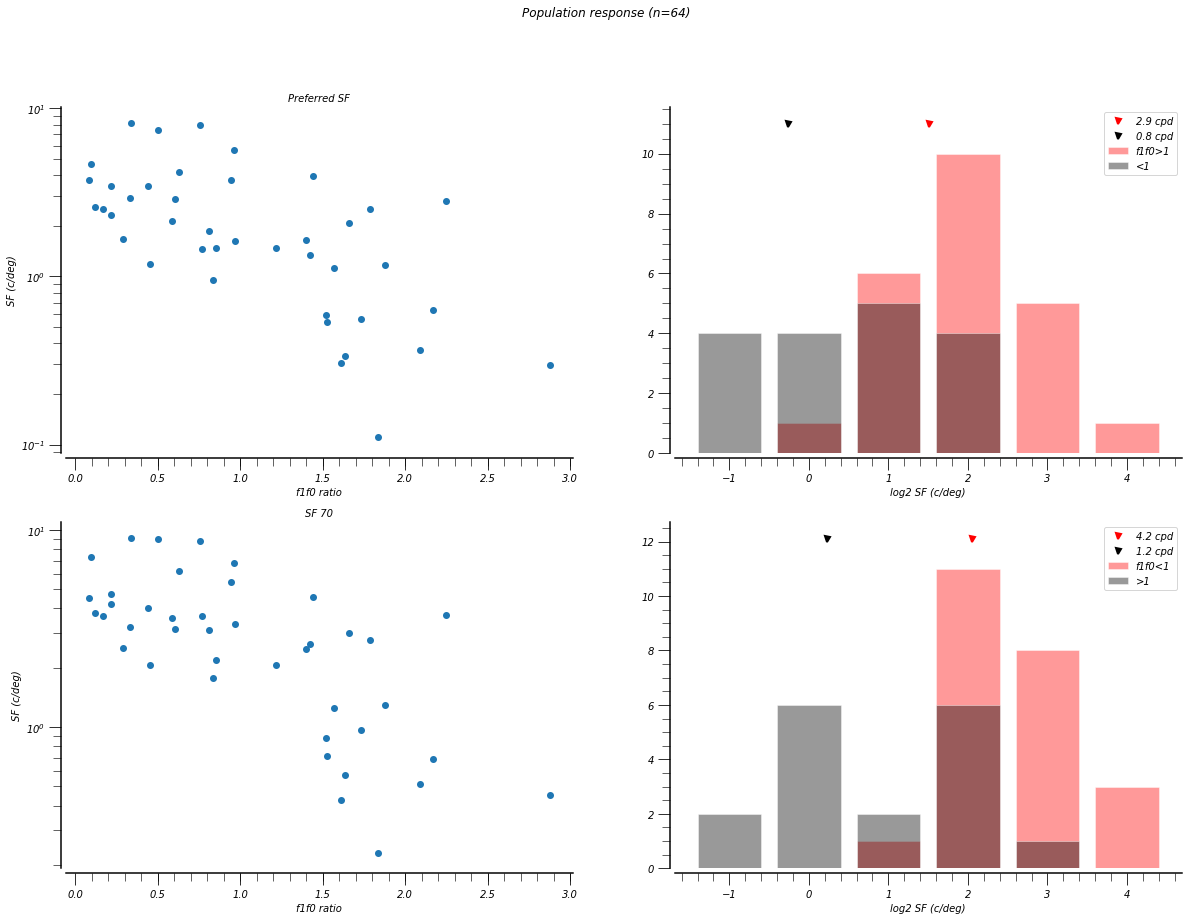

In [1263]:
nrow, ncol = 2,2
f, ax = plt.subplots(nrow, ncol, figsize=(10*ncol, 7*nrow));

### prefSf against f1f0
ax[0,0].semilogy(f1f0, prefSf, 'o');
ax[0,0].set_title('Preferred SF')
ax[0,0].set_ylabel('SF (c/deg)');
ax[0,0].set_xlabel('f1f0 ratio');
### distr. of prefSf - simple vs. complex
# - what's simple, what's complex?
inds_comp = np.where(f1f0<1);
inds_simp = np.where(f1f0>=1);
inds = (inds_comp, inds_simp);
lbls = ('f1f0>1', '<1')
clrs = ('r', 'k');
# - bins (in np.log2...)
sf_bins = np.linspace(-2, 4, 7);
mns = [np.nanmean(np.log2(prefSf[x])) for x in inds];
counts = [np.histogram(np.log2(prefSf[x]), bins=sf_bins)[0] for x in inds]
[ax[0,1].bar(sf_bins[1:], cnts, alpha=0.4, label=lbl, color=clr) for cnts,lbl,clr in zip(counts, lbls, clrs)]
[ax[0,1].plot(mn, 1.1*np.max(counts), 'v', color=clr, label='%.1f cpd' % np.power(2,mn)) for mn,clr in zip(mns, clrs)]
ax[0,1].legend()
ax[0,1].set_xlabel('log2 SF (c/deg)');

### sf70 against f1f0
ax[1,0].semilogy(f1f0, sf70, 'o');
ax[1,0].set_title('SF 70')
ax[1,0].set_ylabel('SF (c/deg)');
ax[1,0].set_xlabel('f1f0 ratio');
### distr. of prefSf - simple vs. complex
# - what's simple, what's complex?
inds_comp = np.where(f1f0<1);
inds_simp = np.where(f1f0>=1);
inds = (inds_comp, inds_simp);
lbls = ('f1f0<1', '>1')
clrs = ('r', 'k');
# - bins (in np.log2...)
sf_bins = np.linspace(-2, 4, 7);
mns = [np.nanmean(np.log2(sf70[x])) for x in inds];
counts = [np.histogram(np.log2(sf70[x]), bins=sf_bins)[0] for x in inds]
[ax[1,1].bar(sf_bins[1:], cnts, alpha=0.4, label=lbl, color=clr) for cnts,lbl,clr in zip(counts, lbls, clrs)]
[ax[1,1].plot(mn, 1.1*np.max(counts), 'v', color=clr, label='%.1f cpd' % np.power(2,mn)) for mn,clr in zip(mns, clrs)]
ax[1,1].legend()
ax[1,1].set_xlabel('log2 SF (c/deg)');

sns.despine(offset=5)

nCls = len(f1f0);
f.suptitle('Population response (n=%d)' % (nCls))
    
saveName = 'sfDistr.pdf'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


# Constructing the M and P front end

### Constructing the SF tuning
Based on the above analysis and the standard difference of gaussians model, we'll construct a representative M and P SF tuning curve:

fc_p: 3.5 c/deg  
fc_m: 2.5 c/deg  

ks_p: 0.5 (a.u.)  
ks_m: 0.35 (a.u.)  

**BUT** we need to make sure that we have selectivity out to the range of stimuli used, so let's ensure that P cells respond to at least 10 cpd


In [701]:
# SET:
gain_m, gain_p = 1, 1;
fc_m, fc_p = 3, 9; 
# fc_m, fc_p = 4, 6.5; - second try
# fc_m, fc_p = 2.5, 3.5; - first try
gs_m, gs_p = 0.3, 0.5;
js_m, js_p = 0.4, 0.4; # parvo 3 to 1 
DoGmodel = 2;

m_clr = 'r'
p_clr = 'b'
j_clr = 'k' # joint color for m&p combined, or m::p ratio

# USE:
dog_m = [gain_m, fc_m, gs_m, js_m];
dog_p = [gain_p, fc_p, gs_p, js_p];

# for plotting:
stim_sf = np.geomspace(0.3, 15, 100);
thresh = 0.05

sf_m = lambda stim_sf: hf.get_descrResp(dog_m, stim_sf, DoGmodel, minThresh=0.1);
sf_p = lambda stim_sf: hf.get_descrResp(dog_p, stim_sf, DoGmodel, minThresh=0.1);

resps_m = sf_m(stim_sf)
resps_p = sf_p(stim_sf)


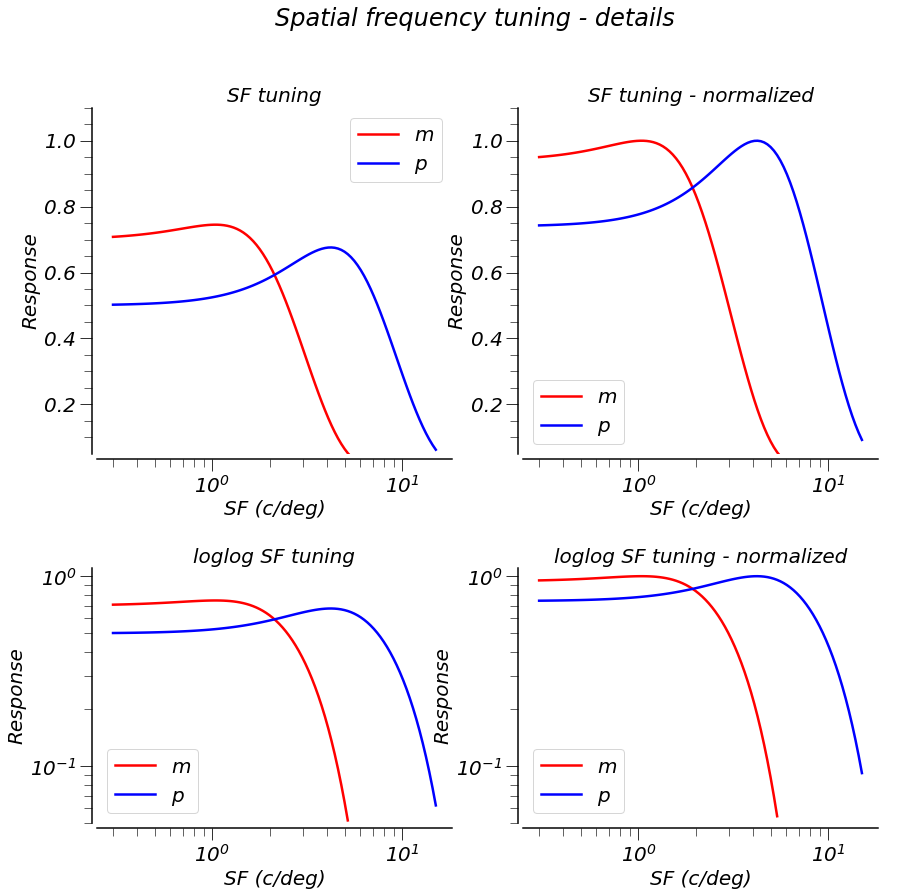

In [702]:
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 7*nrow))

# -- NOT normalized
ax[0,0].semilogx(stim_sf, resps_m, color=m_clr, label='m');
ax[0,0].semilogx(stim_sf, resps_p, color=p_clr, label='p');
ax[0,0].set_title('SF tuning')
# -- normalized
ax[0,1].semilogx(stim_sf, np.divide(resps_m, np.max(resps_m)), color=m_clr, label='m');
ax[0,1].semilogx(stim_sf, np.divide(resps_p, np.max(resps_p)), color=p_clr, label='p');
ax[0,1].set_title('SF tuning - normalized')
# -- NOT normalized
ax[1,0].loglog(stim_sf[resps_m>thresh], resps_m[resps_m>thresh], color=m_clr, label='m');
ax[1,0].loglog(stim_sf[resps_p>thresh], resps_p[resps_p>thresh], color=p_clr, label='p');
ax[1,0].set_aspect('equal');
ax[1,0].set_title('loglog SF tuning')
# -- normalized
norm_m = np.divide(resps_m, np.max(resps_m))
ax[1,1].loglog(stim_sf[norm_m>thresh], norm_m[norm_m>thresh], color=m_clr, label='m');
norm_p = np.divide(resps_p, np.max(resps_p))
ax[1,1].loglog(stim_sf[norm_p>thresh], norm_p[norm_p>thresh], color=p_clr, label='p');
ax[1,1].set_aspect('equal');
ax[1,1].set_title('loglog SF tuning - normalized')

for i, j in itertools.product(np.arange(2), np.arange(2)):
    ax[i,j].set_xlabel('SF (c/deg)');
    ax[i,j].set_ylabel('Response');
    ax[i,j].set_ylim([thresh, 1.1])
    sns.despine(offset=5, ax=ax[i,j])
    ax[i,j].legend();

f.suptitle('Spatial frequency tuning - details')
    
#####
# now, combine and save
#####
saveName = 'details_SF.pdf'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Constructing an RVC function
Based on the analysis in analysesLGN, and the RVC model/equation from Eq. 3 of Movshon, Kiorpes, Hawken, Cavanaugh; 2005, we use the following:

c50_magno: 0.05  
c50_parvo: 0.50  
--- NOTE: the following "k" give the correct contrast gain measures, but we'll adjust the "k" values to match the peak responsivity given in Movshon et al, 05
k_magno: 70  
k_parvo: 10  

Note that we are assuming "b" (parameter 0) is 0, so we just have k (parameter 1) and c50 (parameter 2).  
This also means the contrast gain is simply $k/c_0$

Per Tony (correspondence on 20.07.19): "You know from fig 7 of Movshon et al 2005 that the responsivity (i.e.
initial rvc slope) of M cells is about 250 vs 35 for P cells"

In [704]:
rg_m = 250
rg_p = 35

c50_m = 0.05;
c50_p = 0.5;

k_m_guess = rg_m * c50_m
k_p_guess = rg_p * c50_p

print('With contrast gains, c50 of %d|%.2f and %d|%.2f, respectively, the K parameters of M and P should be around %.2f and %.2f' % (rg_m, c50_m, rg_p, c50_p, k_m_guess, k_p_guess))

With contrast gains, c50 of 250|0.05 and 35|0.50, respectively, the K parameters of M and P should be around 12.50 and 17.50


In [707]:
# SET:
c50_m = 0.05;
c50_p = 0.5;
k_m = 12.5;
k_p = 17.5;
# - first good try for k_m, k_p
# k_m = 20;
# k_p = 40;

# USE:
params_m = [0, k_m, c50_m];
params_p = [0, k_p, c50_p];

# For plotting
cons = np.geomspace(0.001, 1, 100)
rvc_mod = hf.get_rvc_model();

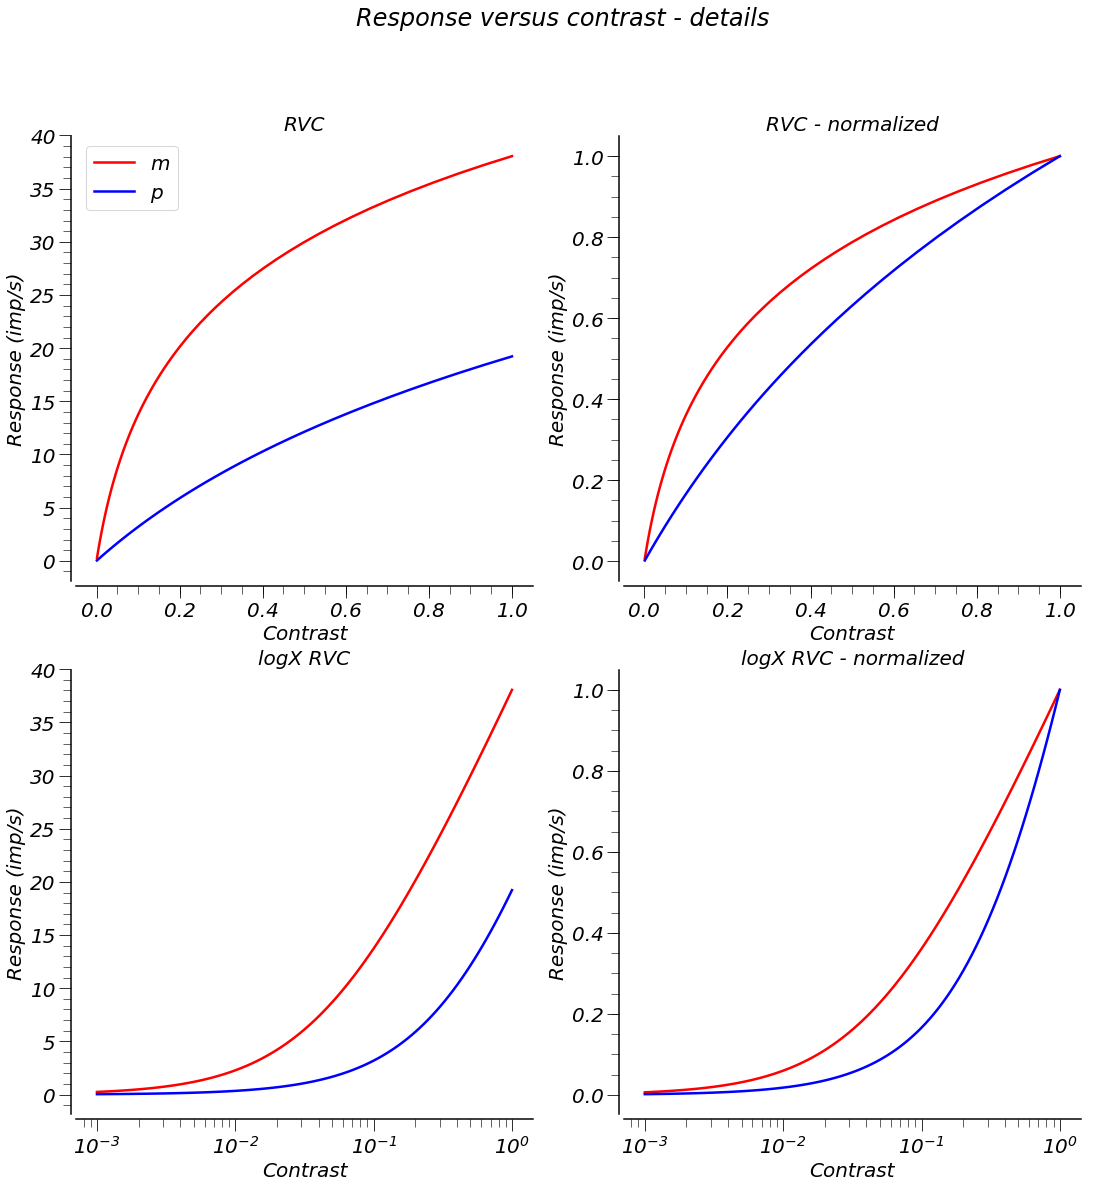

In [708]:
nrow, ncol = 2, 2
f, ax = plt.subplots(nrow, ncol, figsize=(9*ncol, 9*nrow))

rvc_m = lambda c: rvc_mod(*params_m, c);
rvc_p = lambda c: rvc_mod(*params_p, c);

resps_m = rvc_m(cons)
resps_p = rvc_p(cons)
# -- NOT normalized
ax[0,0].plot(cons, resps_m, color=m_clr, label='m');
ax[0,0].plot(cons, resps_p, color=p_clr, label='p');
ax[0,0].set_title('RVC')
ax[0,0].legend();
# -- normalized
ax[0,1].plot(cons, np.divide(resps_m, np.max(resps_m)), color=m_clr, label='m');
ax[0,1].plot(cons, np.divide(resps_p, np.max(resps_p)), color=p_clr, label='p');
ax[0,1].set_title('RVC - normalized')
# -- NOT normalized
ax[1,0].semilogx(cons, resps_m, color=m_clr, label='m');
ax[1,0].semilogx(cons, resps_p, color=p_clr, label='p');
ax[1,0].set_title('logX RVC')
# -- normalized
ax[1,1].semilogx(cons, np.divide(resps_m, np.max(resps_m)), color=m_clr, label='m');
ax[1,1].semilogx(cons, np.divide(resps_p, np.max(resps_p)), color=p_clr, label='p');
ax[1,1].set_title('logX RVC - normalized')

for i, j in itertools.product(np.arange(2), np.arange(2)):
    ax[i,j].set_xlabel('Contrast');
    ax[i,j].set_ylabel('Response (imp/s)');
    sns.despine(offset=5, ax=ax[i,j])
    
f.suptitle('Response versus contrast - details')

#####
# now, combine and save
#####
saveName = 'details_RVC.pdf'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


## The full LGN front-end

We can think of the full LGN response of each class (M, P) as:

$R(f, c) = R(f) * R(c)$, i.e. the response as a function of $f, c$ are separable

Note: We've wrapped up all of the response magnitude difference between Parvo and Magno cells in the RVC (i.e. the SF tuning curves have equal maximum amplitude).

### Equations:

First, for SF tuning, then for RVC

$$S(k, f_c, k_s, j_s; \omega) = k*[\exp(-(\frac{\omega}{f_c})^2 - k_s * \exp(-(\frac{\omega}{f_c*j_s}))^2]$$
$$R(k, c_0; c) = k*log(1+\frac{c}{c_o})$$

### Parameters:
**Magno SF**: $k=1, f_c = 3$ (c/deg), $k_s = 0.3, j_s = 0.4$   
**Magno RVC**: $c_0 = 0.05, k = 12.5$   
**Parvo SF**: $k=1, f_c = 9$ (c/deg), $k_s = 0.5, j_s = 0.4$   
**Parvo RVC**: $c_0 = 0.50, k = 17.5$   

Now, let's plot the parvo/magno responses at various contrasts, and then explore different ratios of M:P input


In [709]:
wght_m = 0.5; # p weight is 1-wght_m

max_m = np.max(sf_m(stim_sf));
max_p = np.max(sf_p(stim_sf));
full_m = lambda stim_sf, c: np.divide(sf_m(stim_sf), max_m) * rvc_m(c)
full_p = lambda stim_sf, c: np.divide(sf_p(stim_sf), max_p) * rvc_p(c)

First, let's assume equal weighting between M and P inputs

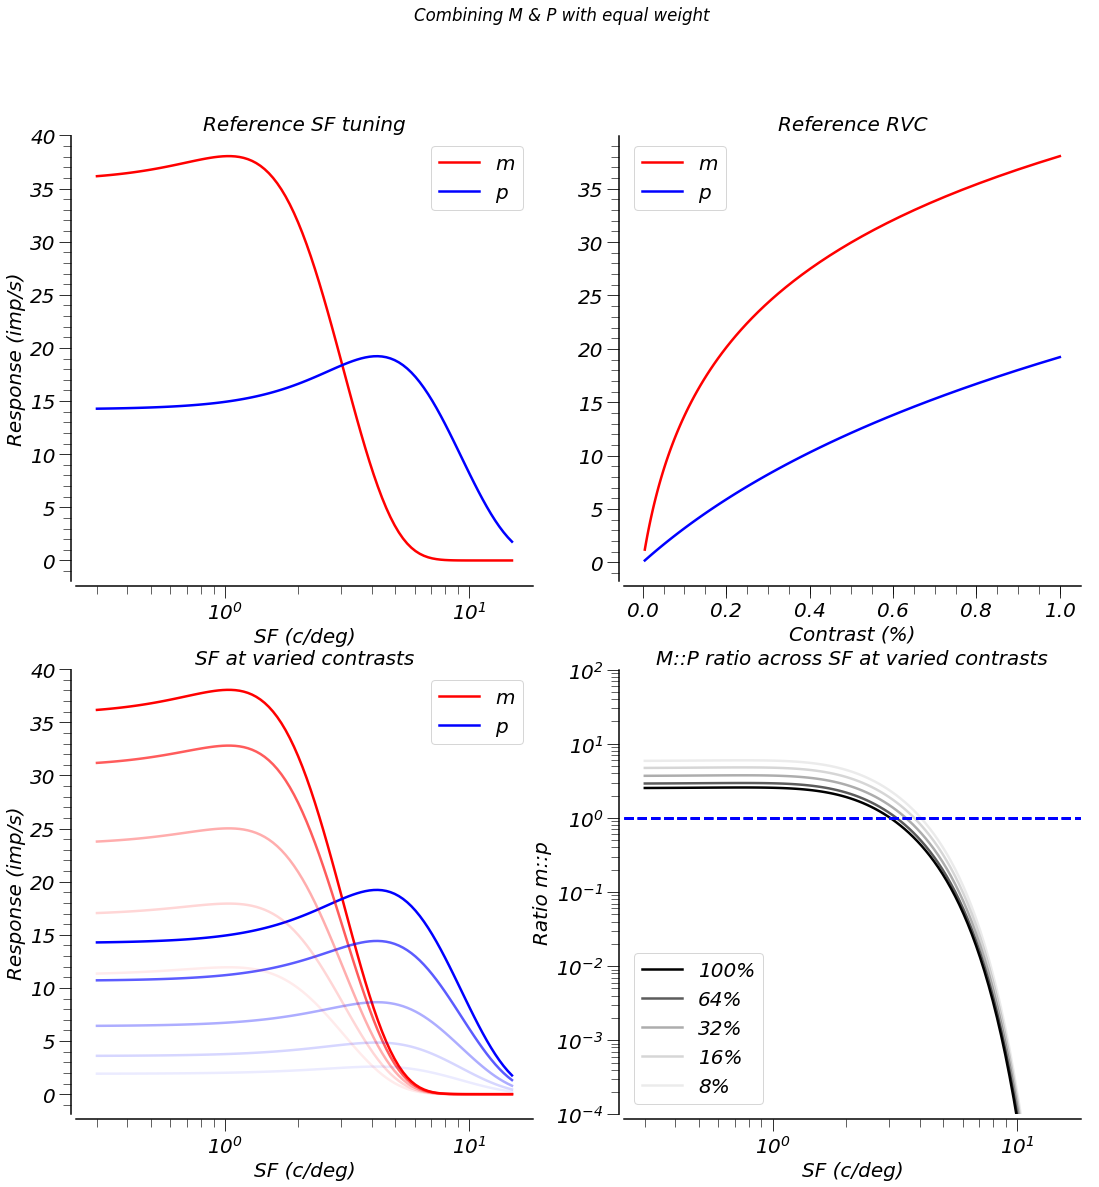

In [710]:
nRows, nCols = 2, 2;
f, ax = plt.subplots(nRows, nCols, figsize=(9*nCols, nRows*9))

### First, reproduce the SF tuning, RVC
# -- SF
stim_sf = np.geomspace(0.3, 15, 100);
ax[0,0].semilogx(stim_sf, full_m(stim_sf, 1), color=m_clr, label='m');
ax[0,0].semilogx(stim_sf, full_p(stim_sf, 1), color=p_clr, label='p');
ax[0,0].set_xlabel('SF (c/deg)');
ax[0,0].set_ylabel('Response (imp/s)');
ax[0,0].set_title('Reference SF tuning')
ax[0,0].legend();

# -- RVC
cons = np.geomspace(0.005, 1, 100);
resps_m = rvc_m(cons)
resps_p = rvc_p(cons)
# -- NOT normalized
ax[0,1].plot(cons, resps_m, color=m_clr, label='m');
ax[0,1].plot(cons, resps_p, color=p_clr, label='p');
ax[0,1].set_xlabel('Contrast (%)');
ax[0,1].set_title('Reference RVC')
ax[0,1].legend();

### Now, show what happens as a f'n of contrast to the SF tuning
cons = [0.08, 0.16, .32, 0.64, 1]
wght_p = 1-wght_m;

ax[1,0].set_title('SF at varied contrasts')
ax[1,1].set_title('M::P ratio across SF at varied contrasts')

for cc in reversed(cons):

    curr_m = full_m(stim_sf, cc);
    curr_p = full_p(stim_sf, cc);

    # -- NOT normalized
    if cc == np.max(cons):
        ax[1, 0].semilogx(stim_sf, curr_m, color=m_clr, alpha=cc, label='m');
        ax[1, 0].semilogx(stim_sf, curr_p, color=p_clr, alpha=cc, label='p');
        ax[1, 0].set_ylabel('Response (imp/s)');
    else:
        ax[1, 0].semilogx(stim_sf, curr_m, color=m_clr, alpha=cc);
        ax[1, 0].semilogx(stim_sf, curr_p, color=p_clr, alpha=cc);

    # -- RATIO of M::P
    m_to_p = np.divide(curr_m, curr_p);
    ax[1, 1].loglog(stim_sf, m_to_p, color=j_clr, alpha=cc, label='%d%%' % (100*cc));
    ax[1, 1].set_ylabel('Ratio m::p');
    ax[1, 1].set_ylim([1e-4, 1e2])
    ax[1, 1].axhline(1, color=p_clr, ls='--')

    for nc in range(nCols):
        ax[1, nc].set_xlabel('SF (c/deg)');
        ax[1, nc].legend();

f.suptitle('Combining M & P with equal weight', fontsize='small')
        
sns.despine(offset=5)

saveName = 'full_basic.pdf'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

As expected from their high contrast gain, the M cell is more dominant at low contrasts - both in terms of the ratio of M::P and in the range of frequencies for which the M input is greater than P input.

But now, let's explore a range of weights and show the SF/RVC tunings for the combined front-end (as well as M::P ratio)

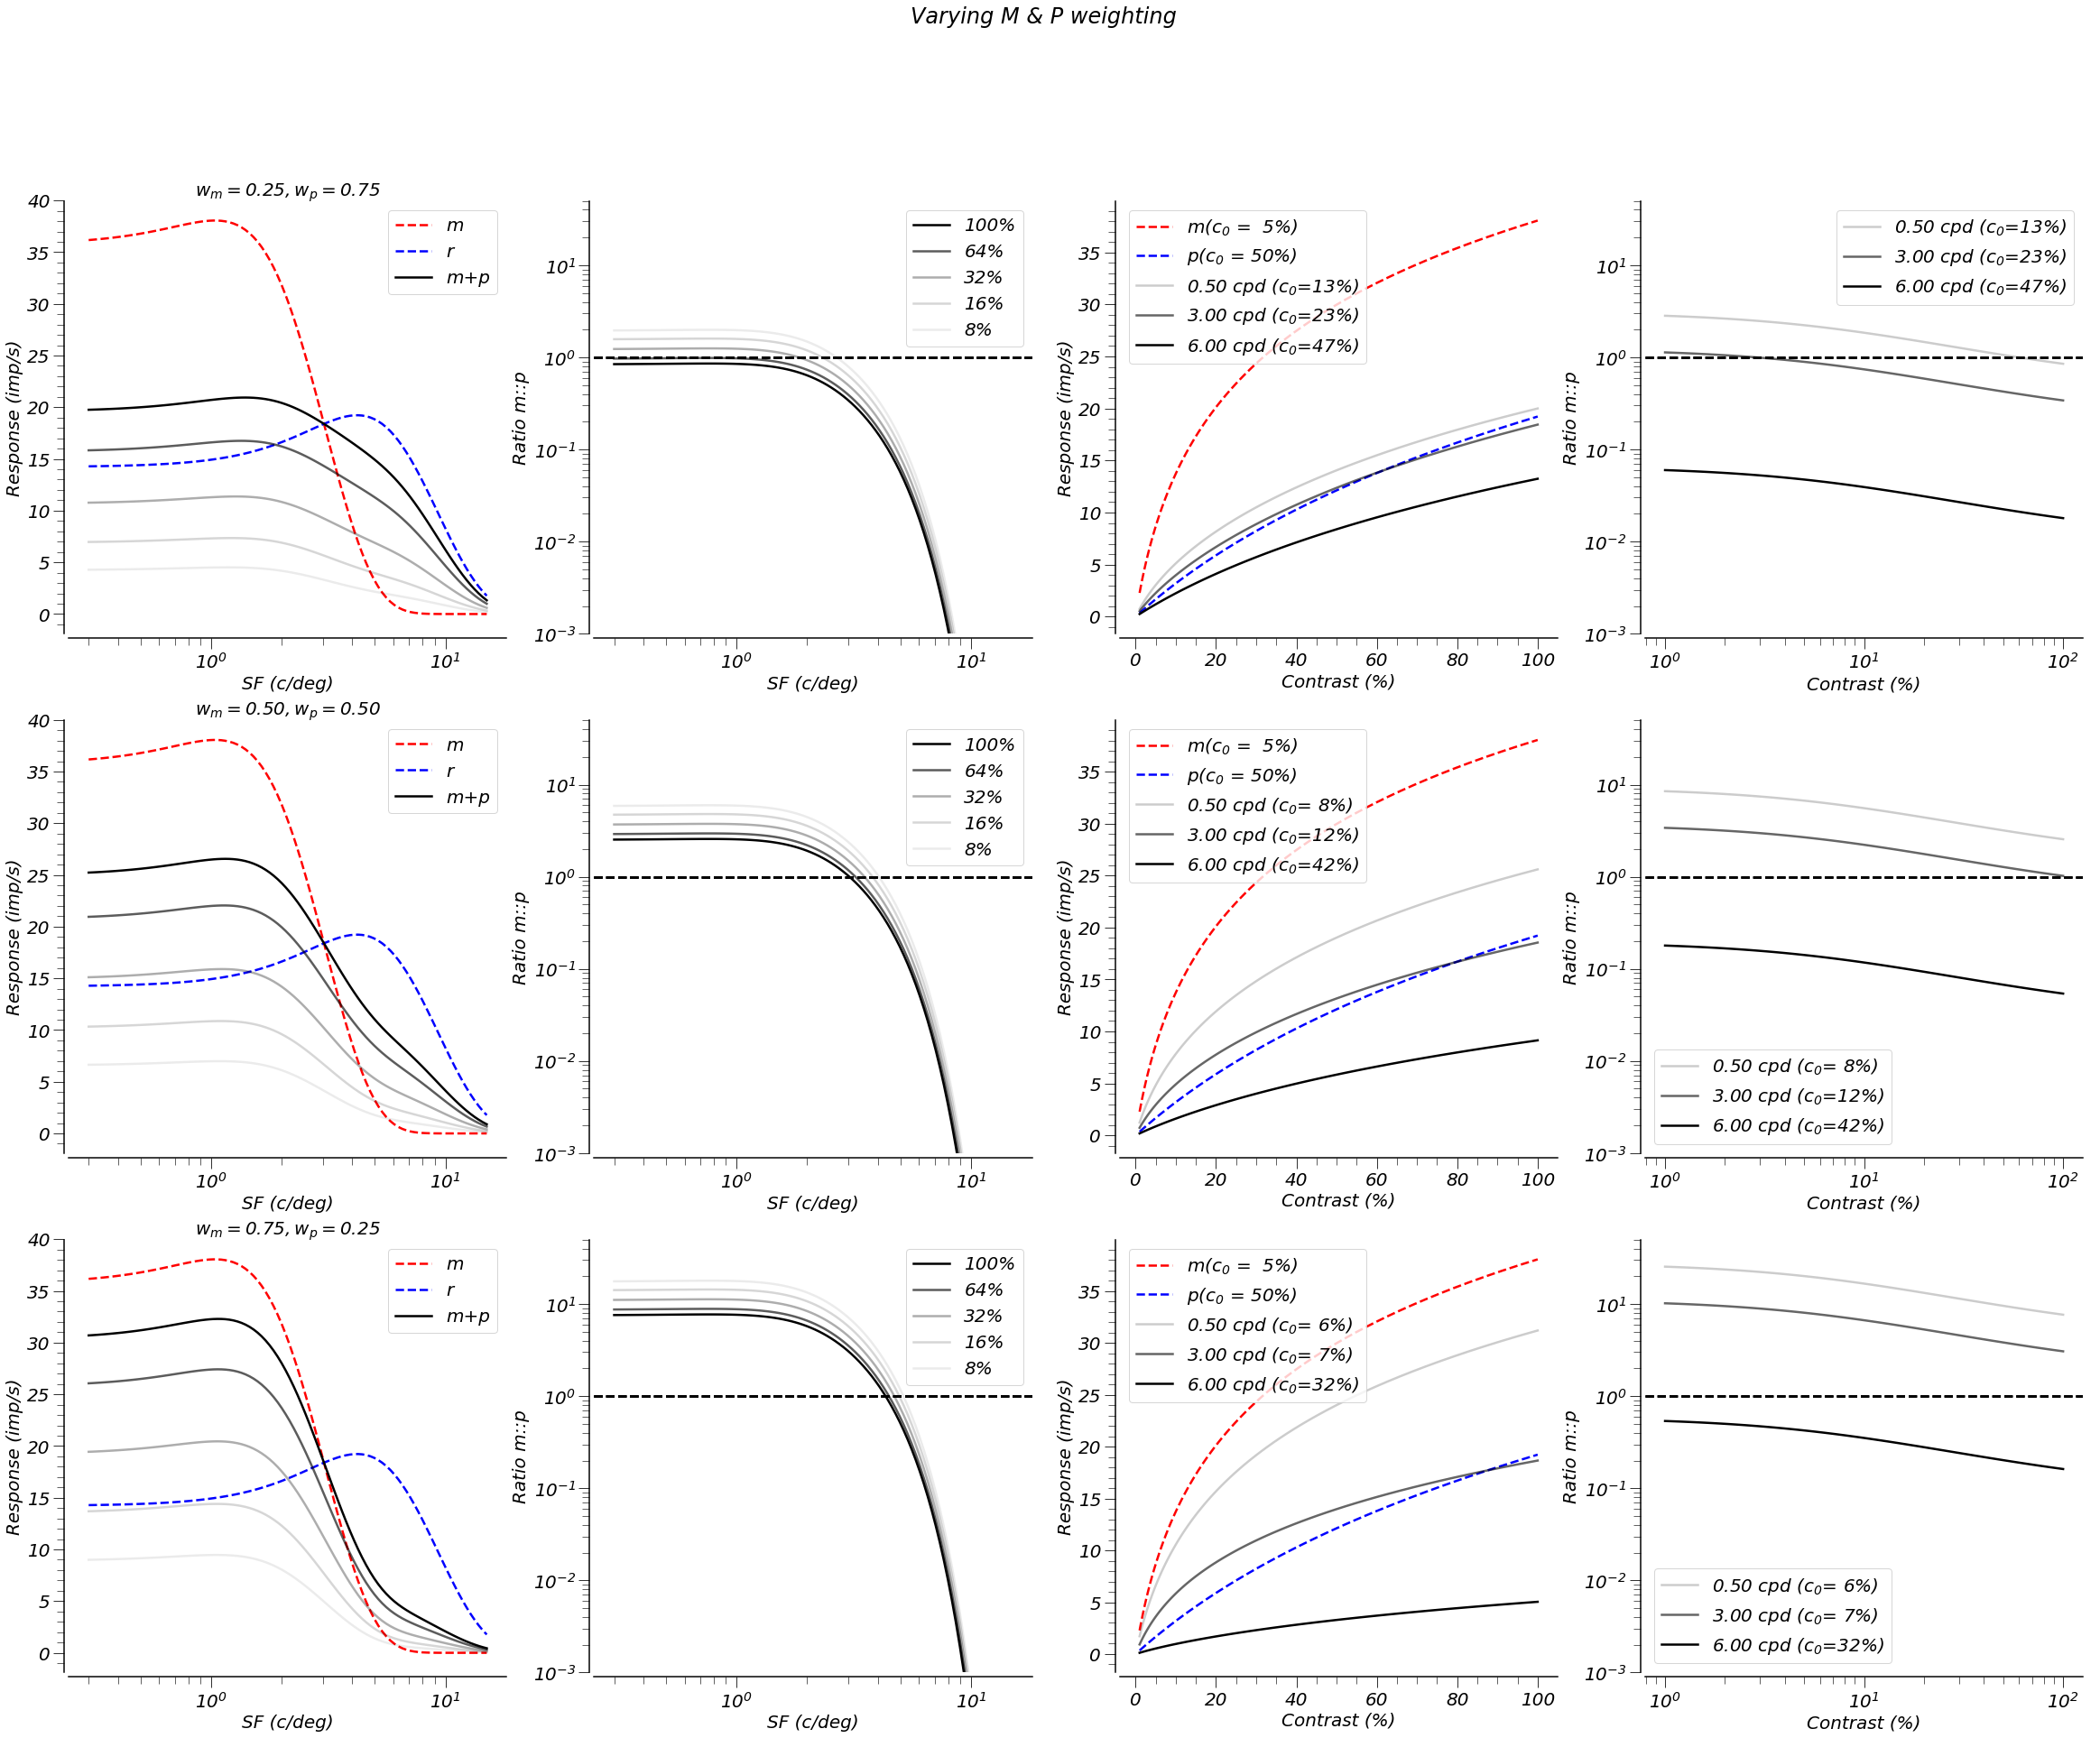

In [711]:
### What to explore in this plot?
# - weights for M
wghts = np.linspace(0.25, 0.75, 3)
# - cons for SF tuning curves
cons = [0.08, 0.16, .32, 0.64, 1]
# - SFS for RVC curves
sfs = [0.5, 3, 6]; # cpd


### Now, plot!

nRows, nCols = len(wghts), 4;
f, ax = plt.subplots(nRows, nCols, figsize=(10*nCols, nRows*10))

for nr in range(nRows):
    for nc in range(nCols-1):
        ax[nr, nc].set_xlabel('SF (c/deg)');

for i, m_w in enumerate(wghts):

    wght_m = m_w;
    wght_p = 1-m_w;
    
    for cc in reversed(cons):
        
        curr_m = full_m(stim_sf, cc);
        curr_p = full_p(stim_sf, cc);

        full_resp = wght_m*curr_m + wght_p*curr_p

        # also plot the refernce M and P:
        if cc == np.max(cons):
            ax[i, 0].semilogx(stim_sf, curr_m, color=m_clr, ls='--', label='m');
            ax[i, 0].semilogx(stim_sf, curr_p, color=p_clr, ls='--', label='r');
            ax[i, 0].set_title(r'$w_m = %.2f, w_p = %.2f$' % (wght_m, wght_p))
            ax[i, 0].set_ylabel('Response (imp/s)');
            ax[i, 0].semilogx(stim_sf, full_resp, color=j_clr, alpha=cc, label='m+p');
            ax[i, 0].legend();
        else:
            ax[i, 0].semilogx(stim_sf, full_resp, color=j_clr, alpha=cc);

        # -- RATIO of M::P
        m_to_p = np.divide(wght_m*curr_m, wght_p*curr_p);
        ax[i, 1].loglog(stim_sf, m_to_p, color=j_clr, alpha=cc, label='%d%%' % (100*cc));
        ax[i, 1].set_ylabel('Ratio m::p');
        ax[i, 1].axhline(1, color='k', ls='--')
        ax[i, 1].set_ylim([1e-3, 5e1])
        ax[i, 1].legend()

    # RVC at different SF
    # -- first, the reference RVCs
    sf_cons = np.geomspace(0.01, 1, 100);
    resps_m = rvc_m(sf_cons)
    resps_p = rvc_p(sf_cons)
    # -- NOT normalized
    ax[i,2].plot(100*sf_cons, resps_m, color=m_clr, ls='--', label=r'$m (c_0$ = %2d%%)' % (100*c50_m));
    ax[i,2].plot(100*sf_cons, resps_p, color=p_clr, ls='--', label=r'$p (c_0$ = %2d%%)' % (100*c50_p));
    ax[i,2].set_xlabel('Contrast (%)');
    ax[i,3].set_xlabel('Contrast (%)');

    alphs = np.linspace(0.2, 1, len(sfs));
    for clr_i, sf in enumerate(sfs):
        m_resp = wght_m*full_m(sf, sf_cons);
        p_resp = wght_p*full_p(sf, sf_cons);
        full_resp = m_resp + p_resp;
        curr_fit = hf.rvc_fit([full_resp], [sf_cons], mod=0, fix_baseline=True, n_repeats=10)[1]; # index for parameters
        curr_c50 = hf.get_c50(rvcMod=0, params=curr_fit[0]) # unpack the array of curr_fit params
        ax[i,2].plot(100*sf_cons, full_resp, color=j_clr, alpha=alphs[clr_i], label=r'%.2f cpd $(c_0$=%2d%%)' % (sf, 100*curr_c50));
        ax[i,2].set_ylabel('Response (imp/s)');
        ax[i,2].legend();
        
        # -- RATIO of M::P
        m_to_p = np.divide(m_resp, p_resp);
        ax[i, 3].loglog(100*sf_cons, m_to_p, color=j_clr, alpha=alphs[clr_i], label=r'%.2f cpd $(c_0$=%2d%%)' % (sf, 100*curr_c50));
        ax[i, 3].set_ylabel('Ratio m::p');
        ax[i, 3].axhline(1, color='k', ls='--')
        ax[i, 3].set_ylim([1e-3, 5e1])
        ax[i, 3].legend()
        
sns.despine(offset=5)
f.suptitle('Varying M & P weighting')

saveName = 'full_varied_weights.pdf'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Contour plots, too! Regions of **red** correspond to magno dominance over parvo input; **blue** corresponds to parvo stronger than magno. As expected from our choice that Magno has a higher maximum response than Parvo, the stimulus space is more heavily "covered" by magno even with equal weighting of the two cells. A more careful analysis might also consider the coverage of our stimulus set over the range of stimuli evaluated in these contour plots.

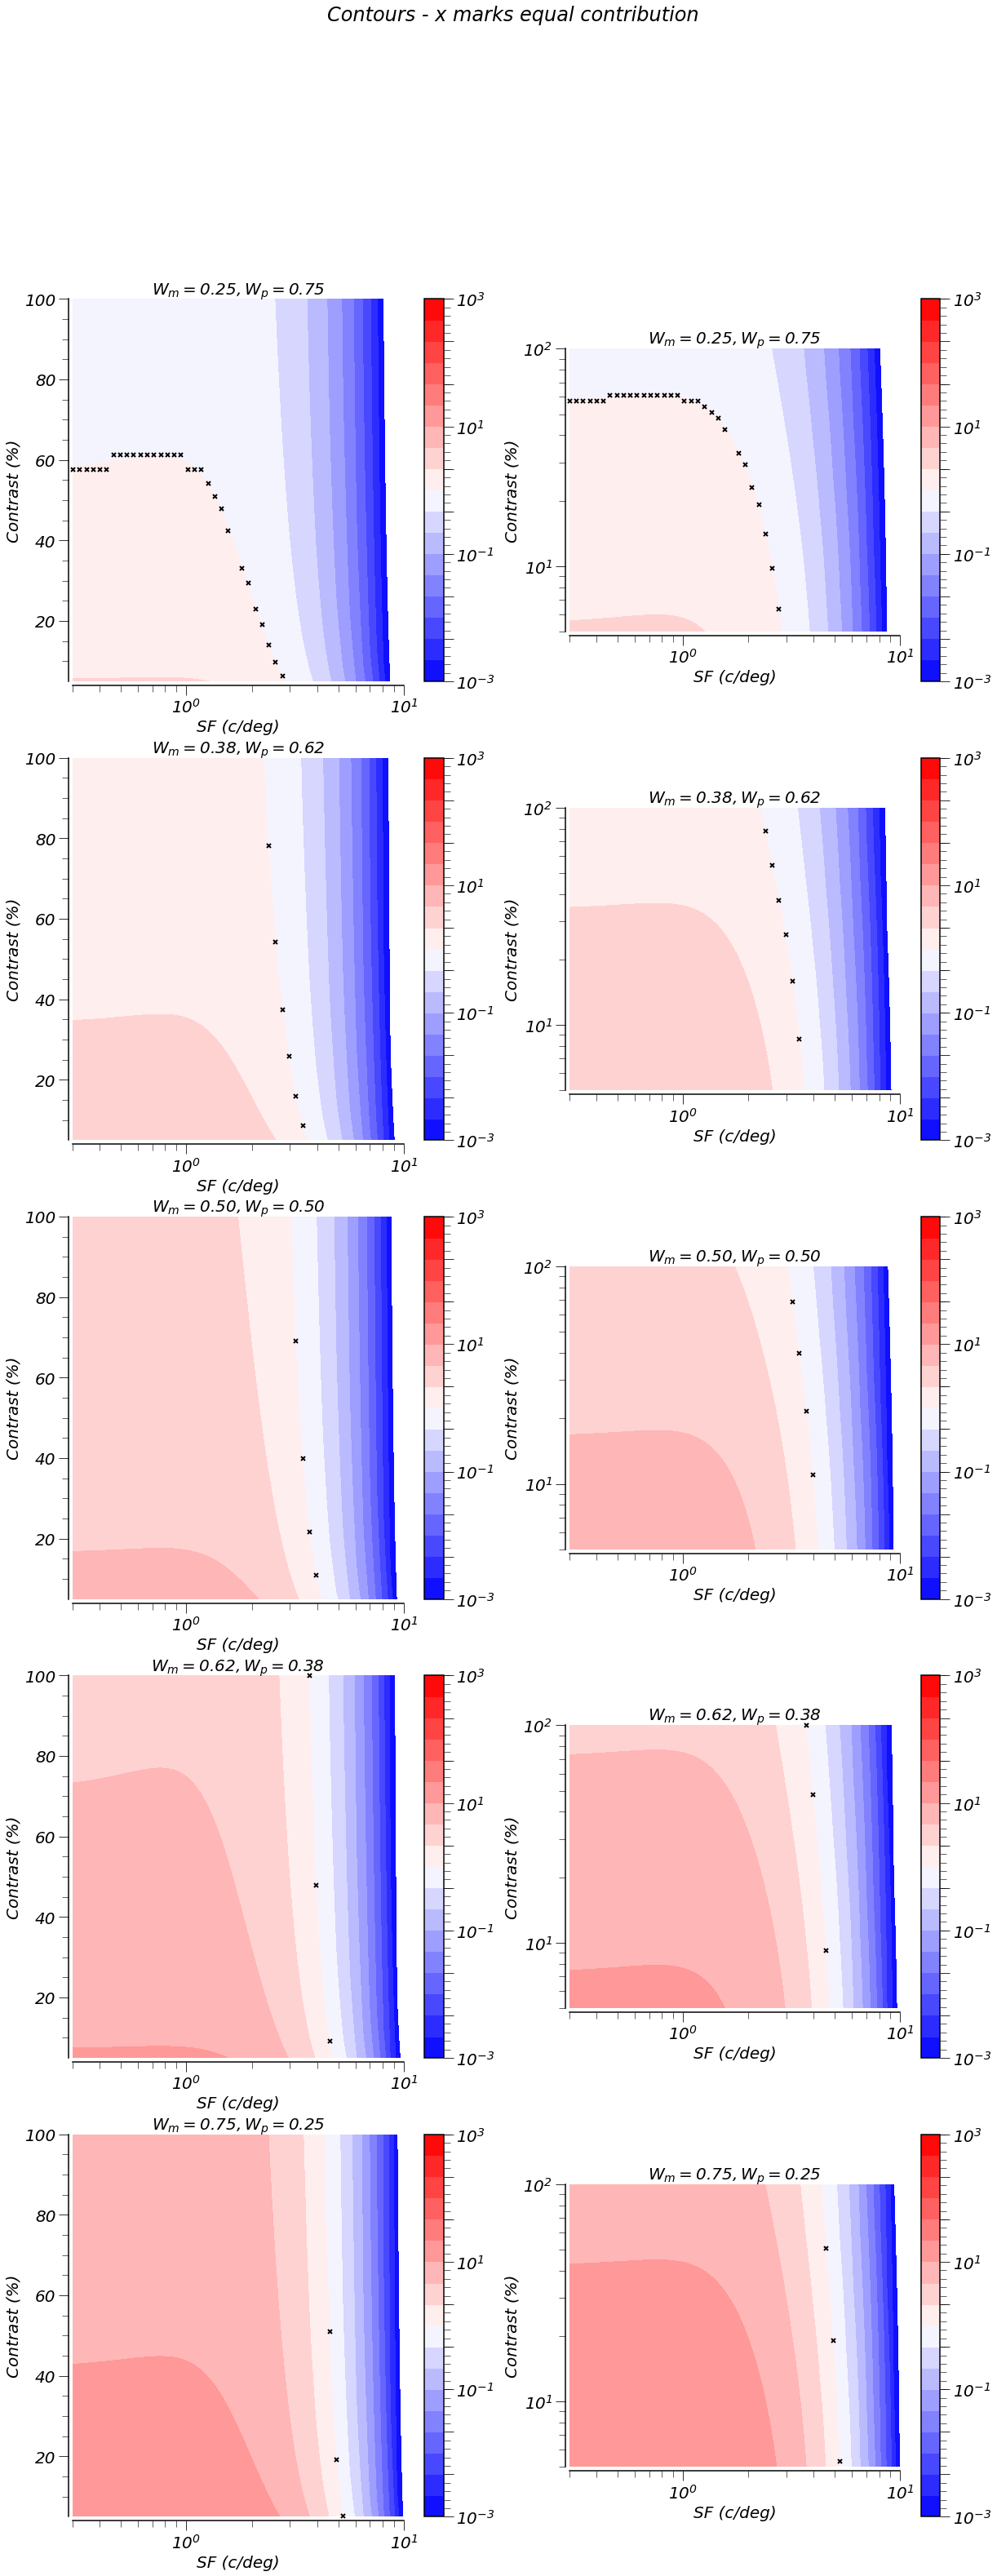

In [712]:
# then, we'll also make a 2d contour plot to examine the balance of M vs P input across the stimulus space
wghts = np.linspace(0.25, 0.75, 5)

sfs_grid = np.geomspace(0.3, 10, 50);
cns_grid = np.geomspace(0.05, 1, 50);
mg = np.meshgrid(sfs_grid, cns_grid);

eq1_thresh = 1e-2; # what is the tol. (+/-) rel to 1 where we consider M and P inputs equal

nwts = len(wghts)
ncol = 2; # one for lin con, other for log con.
f, ax = plt.subplots(nwts, ncol, figsize=(10*ncol, 10*nwts))

for i, m_w in enumerate(wghts):

    wght_m = m_w;
    wght_p = 1-m_w;
       
    m_resp = wght_m*full_m(mg[0], mg[1])
    p_resp = wght_p*full_p(mg[0], mg[1])
    m_to_p = np.divide(m_resp, p_resp);
        
    ### contour plot!
    mx = 3; # max color to make (10e[+/-MX])
    lvls = np.linspace(-mx, mx, 6*mx+1) # 6*mx+1 levels to color
    m_to_p = np.divide(m_resp, p_resp);
    xeq, yeq = np.where(np.abs(m_to_p-1)<eq1_thresh);

    for jj in range(ncol):
    
        ax[i, jj].set_title(r'$W_m = %.2f, W_p = %.2f$' % (wght_m, wght_p))
        cs = ax[i, jj].contourf(mg[0], 100*mg[1], m_to_p, cmap=cm.bwr, norm = mplclr.LogNorm(), levels=[np.power(10,x) for x in lvls]);
        [ax[i, jj].plot(sfs_grid[yy], 100*cns_grid[xx], 'kx', clip_on=False) for xx,yy in zip(xeq,yeq)]
        ax[i, jj].set_xscale('log');
        ax[i, jj].set_xlabel('SF (c/deg)')
        ax[i, jj].set_ylabel('Contrast (%)')
        f.colorbar(cs, ax=ax[i, jj])
        sns.despine(offset=5, ax=ax[i, jj])
        
        if jj == 1:
            ax[i, jj].set_yscale('log');
            ax[i, jj].set_aspect('equal')

f.suptitle('Contours - x marks equal contribution')
    
saveName = 'full_contour.pdf'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()